# APPLIED AI IN *BIOMEDICINE*

## SETUP

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /path_to_folder/train

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1hA7wlLn1BX4PUggVnvffCbAB59TOlChy/projectHeart/train


In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
np.random.seed(seed)
import logging
import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.signal import butter, lfilter, filtfilt, resample
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Concatenate, Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.utils import class_weight
import scipy.io

2.15.0


## FUNCTIONS

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def plot_confusionMatrix(test_labels, test_predicted, clf):
  cm = confusion_matrix(test_labels, test_predicted, labels=clf.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=['NSR', 'AF'])
  disp.plot()
  plt.show()
  return

def testModel(train_features, train_labels, test_features, test_labels, clf):
  clf.fit(train_features, train_labels)
  # d. Predit test labels
  test_predicted = clf.predict(test_features)
  # e. plot confusion matrix
  plot_confusionMatrix(test_labels, test_predicted, clf)
  # f. display classification results
  print(classification_report(test_labels, test_predicted, target_names=['NSR', 'AF']))

def plot_correlationMatrix(correlation_matrix, features):
    f = plt.figure(figsize=(10, 8))
    plt.matshow(correlation_matrix, fignum=f.number)
    plt.xticks(range(len(features)), features, fontsize=10, rotation=90)
    plt.yticks(range(len(features)), features, fontsize=10)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    #plt.title('Correlation Matrix', fontsize=16)
    # plt.tight_layout()
    return

def plot_PCAanalysis(train_features_pca, pc_plot):
  principalComponents_Df = pd.DataFrame(data = train_features_pca[:,pc_plot],
                                      columns = ['principal component 1', 'principal component 2'])
  plt.figure()
  plt.figure(figsize=(10,10))
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=14)
  plt.xlabel('Principal Component - 1',fontsize=20)
  plt.ylabel('Principal Component - 2',fontsize=20)
  plt.title("Principal Component Analysis",fontsize=20)
  targets = [0, 1]
  colors = ['r', 'g']
  for target, color in zip(targets,colors):
    indicesToKeep = np.array(train_labels) == target
    plt.scatter(principalComponents_Df.loc[indicesToKeep, 'principal component 1']
                , principalComponents_Df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

  plt.legend(targets,prop={'size': 15})
  return

def plot_recurrentFE(min_features_to_select, rfecv):
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Cross validation score (accuracy)")
  plt.plot(range(min_features_to_select,
                len(rfecv.grid_scores_) + min_features_to_select),
          rfecv.grid_scores_)
  plt.show()

def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
    """
    Method responsible for creating and applying Butterworth filter.
    :param deque data: raw data
    :param float lowcut: filter lowcut frequency value
    :param float highcut: filter highcut frequency value
    :param int signal_freq: signal frequency in samples per second (Hz)
    :param int filter_order: filter order
    :return array: filtered data
    """
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(filter_order, [low, high], btype="band")
    y = lfilter(b, a, data)
    return y

def plot_patient_data(start,length, patient_index, ppg_list, ppg_list_speaks, ppg_list_ann, xl=None):
    end = start + length

    # Creare un array di indici per la serie ppg_list
    indici = np.arange(start, end)

    # Creazione del grafico
    plt.figure(figsize=(15, 6))  # Imposta la larghezza della figura

    plt.plot(indici, ppg_list[patient_index][start:end], label='ppg_list')

    # Aggiungi linee verticali in corrispondenza dei valori in ppg_list_speaks
    for peak, category in zip(ppg_list_speaks[patient_index], ppg_list_ann[patient_index]):
        if start < peak < end:
            linestyle = '--'
            label = 'Picco'

            # Imposta il colore in base alla categoria del picco
            if category == 'N':
                color = 'green'
            elif category == 'S':
                color = 'blue'
            elif category == 'V':
                color = 'yellow'
            else:
                color = 'black'  # Imposta un colore di default se la categoria non è N, S o V

            plt.axvline(x=peak, color=color, linestyle=linestyle, label=label)

    # Aggiungi titoli e etichette se necessario
    plt.title(f'Grafico di ppg_list per Paziente {patient_index} con Linee Verticali per Picchi')
    plt.xlabel('Indice')
    plt.ylabel('Valore')

    # Aggiungi la legenda
    #plt.legend(prop={'size': 6})

    if xl:
        plt.xlim(xl)
    # Rendi il grafico interattivo
    plt.tight_layout()
    return plt.xlim()

def standardize_ppg(input_ppg):
    '''
    Standardization of the PPG signal
    '''
    scaler = StandardScaler()
    standardized_signal = scaler.fit_transform(input_ppg.reshape(-1, 1)).flatten()
    return standardized_signal

## IMPORT DATA

In [ ]:
# Load MATLAB file
mat_file = scipy.io.loadmat('S057_128.mat')

# Access data from the MATLAB file
# For example, if your MATLAB file contains a variable named 'data', you can access it like this:
#data = mat_file['ppg']

# Print the data
print(type(mat_file))
print(mat_file)

<class 'dict'>
{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACA64, Created on: Tue Nov  7 09:57:37 2023', '__version__': '1.0', '__globals__': [], 'ppg': array([[-2.69036   ],
       [-2.69031554],
       [-2.69026462],
       ...,
       [ 6.70135321],
       [ 7.0942836 ],
       [ 7.03416793]])}


In [ ]:
cartella = os.getcwd()  # Ottieni il percorso corrente
files = os.listdir(cartella)

# Inizializza una lista
ppg_list_250=[]
ppg_list_250_ann=[]
ppg_list_250_speaks=[]

ppg_list_128 =[]
ppg_list_128_ann=[]
ppg_list_128_speaks=[]

for file in files:
    if '250.mat' in file:
        mat_file = scipy.io.loadmat(file)
        # Estrai i dati dal file e aggiungili all'array
        ppg_signal = mat_file['ppg']
        ppg_list_250.append(ppg_signal)
        # Load peaks corresponding to ppg
        mat_file = scipy.io.loadmat(file.replace('.mat', '_spk.mat'))
        speaks = mat_file['speaks']
        ppg_list_250_speaks.append(speaks)
        # Load annotations corresponding to ppg
        mat_file = scipy.io.loadmat(file.replace('.mat', '_ann.mat'))
        speaks = mat_file['labels']
        ppg_list_250_ann.append(speaks)

    if '128.mat' in file:
        mat_file = scipy.io.loadmat(file)
        # Estrai i dati dal file e aggiungili all'array
        ppg_signal = mat_file['ppg']
        ppg_list_128.append(ppg_signal)
        # Load peaks corresponding to ppg
        mat_file = scipy.io.loadmat(file.replace('.mat', '_spk.mat'))
        speaks = mat_file['speaks']
        ppg_list_128_speaks.append(speaks)
        # Load annotations corresponding to ppg
        mat_file = scipy.io.loadmat(file.replace('.mat', '_ann.mat'))
        speaks = mat_file['labels']
        ppg_list_128_ann.append(speaks)


In [ ]:
print("****************PATIENTS WITH 250 SAMPLE FREQUENCY:***********************")
print(f"Number of PPG signals arrays: {len(ppg_list_250)}")
print(f"Number of Speaks arrays: {len(ppg_list_250_speaks)}")
print(f"Number of Annotations arrays: {len(ppg_list_250_ann)}")
print(f"Length of signal 0: {len(ppg_list_250[0])}")
print(f"Length of speaks array[0]: {len(ppg_list_250_speaks[0])}")
print(f"Length of annotation speaks array[0]: {len(ppg_list_250_ann[0])}")
print(f"Examples of ppg_list_250_speaks[39][830:840]: {ppg_list_250_speaks[39][830:840]}")
print(f"Examples of ppg_list_250_ann[39][830:840]:{ppg_list_250_ann[39][830:840]}")

****************PATIENTS WITH 250 SAMPLE FREQUENCY:***********************
Number of PPG signals arrays: 43
Number of Speaks arrays: 43
Number of Annotations arrays: 43
Length of signal 0: 450000
Length of speaks array[0]: 591
Length of annotation speaks array[0]: 591
Examples of ppg_list_250_speaks[39][830:840]: [[179011]
 [179202]
 [179396]
 [179588]
 [179783]
 [394959]
 [215440]
 [215602]
 [215817]
 [216004]]
Examples of ppg_list_250_ann[39][830:840]:['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']


In [ ]:
print("****************PATIENTS WITH 128 SAMPLE FREQUENCY:***********************")
print(f"Number of PPG signals arrays: {len(ppg_list_128)}")
print(f"Number of Speaks arrays: {len(ppg_list_128_speaks)}")
print(f"Number of Annotations arrays: {len(ppg_list_128_ann)}")
print(f"Length of signal 0: {len(ppg_list_128[0])}")
print(f"Length of speaks array[0]: {len(ppg_list_128_speaks[0])}")
print(f"Length of annotation speaks array[0]: {len(ppg_list_128_ann[0])}")
print(f"Examples of ppg_list_128_speaks[39][830:840]: {ppg_list_128_speaks[39][830:840]}")
print(f"Examples of ppg_list_128_ann[39][830:840]:{ppg_list_128_ann[39][830:840]}")

****************PATIENTS WITH 128 SAMPLE FREQUENCY:***********************
Number of PPG signals arrays: 62
Number of Speaks arrays: 62
Number of Annotations arrays: 62
Length of signal 0: 230209
Length of speaks array[0]: 1706
Length of annotation speaks array[0]: 1706
Examples of ppg_list_128_speaks[39][830:840]: [[70995]
 [71046]
 [71166]
 [71232]
 [71330]
 [71423]
 [71507]
 [71560]
 [71669]
 [71757]]
Examples of ppg_list_128_ann[39][830:840]:['N' 'V' 'N' 'N' 'N' 'N' 'N' 'V' 'N' 'N']


I segnali di freq=250 sono tutti lunghi 450000.

I segnali di freq=128 sono piu o meno lunghi tutti 230300. (vedi distribuzione boxplot)


[230209, 230270, 230371, 230346, 230285, 230335, 230213, 230277, 230308, 230293, 230312, 230388, 230443, 230285, 230297, 230332, 230312, 230295, 230458, 230279, 230323, 230341, 230356, 230359, 230289, 230309, 230264, 230371, 230342, 230333, 230334, 230435, 230315, 230312, 230420, 230355, 230334, 230323, 230162, 230379, 230235, 230299, 230261, 230426, 230206, 230158, 230292, 230374, 230400, 230345, 230289, 230361, 230317, 230270, 230090, 230288, 230382, 230401, 230311, 230356, 230402, 230373]


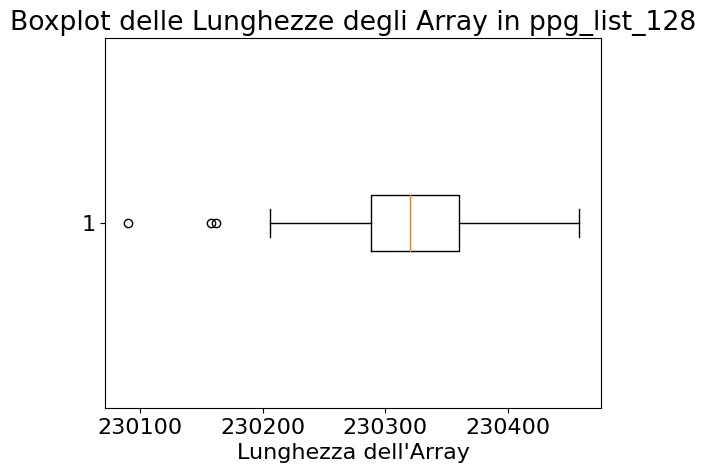

In [ ]:
# Calcola le lunghezze di ciascun array
lunghezze_array = [len(arr) for arr in ppg_list_128]
print(lunghezze_array)
# # Creazione del grafico a barre
# plt.bar(range(len(ppg_list_128)), lunghezze_array, color='blue')
# plt.title('Lunghezza di ciascun Array in ppg_list_128')
# plt.xlabel('Indice dell\'Array')
# plt.ylabel('Lunghezza dell\'Array')
# plt.show()

# Creazione del boxplot
plt.boxplot(lunghezze_array, vert=False)
plt.title('Boxplot delle Lunghezze degli Array in ppg_list_128')
plt.xlabel('Lunghezza dell\'Array')
plt.show()

[591, 2166, 2025, 2168, 2314, 3207, 2192, 1982, 2448, 2358, 2073, 1831, 2957, 2395, 2556, 2368, 2761, 2191, 2409, 2088, 2565, 1867, 1878, 1577, 2114, 2413, 2914, 3037, 2412, 1847, 2505, 1870, 2729, 2566, 2218, 2585, 1851, 2428, 1938, 1890, 3509, 2298, 2262]


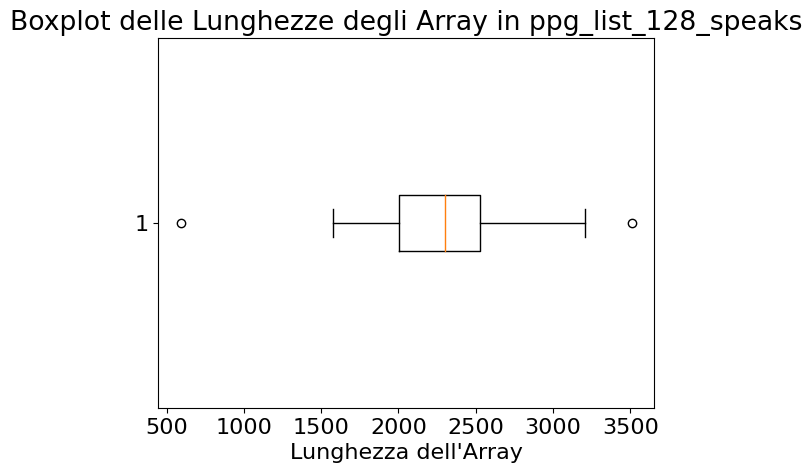

In [ ]:
# Calcola le lunghezze di ciascun array
lunghezze_array = [len(arr) for arr in ppg_list_250_ann]
print(lunghezze_array)
# # Creazione del grafico a barre
# plt.bar(range(len(ppg_list_128)), lunghezze_array, color='blue')
# plt.title('Lunghezza di ciascun Array in ppg_list_128')
# plt.xlabel('Indice dell\'Array')
# plt.ylabel('Lunghezza dell\'Array')
# plt.show()

# Creazione del boxplot
plt.boxplot(lunghezze_array, vert=False)
plt.title('Boxplot delle Lunghezze degli Array in ppg_list_128_speaks')
plt.xlabel('Lunghezza dell\'Array')
plt.show()

array 0 e 39 di ppg_list_250_speaks non sono in ordine crescente.

ppg_list_128_speaks è in ordine crescente

In [ ]:
# Verifica e stampa se i numeri sono in ordine crescente per ciascun array
for i, array in enumerate(ppg_list_250_speaks):
    is_in_ordine_crescente = all(array[j] <= array[j + 1] for j in range(len(array) - 1))

    if is_in_ordine_crescente:
        pass
        #print(f"L'array {i} è in ordine crescente.")
    else:
        print(f"L'array {i} non è in ordine crescente.")

L'array 0 non è in ordine crescente.
L'array 39 non è in ordine crescente.


PROVVISORIO: elimino gli array 0 e 39 che non sono in ordine crescente

[imp: farlo per tutte e tre le liste]

In [ ]:
# Crea una nuova lista contenente solo gli array in ordine crescente e aggiorna le altre due liste
ppg_list_250, ppg_list_250_speaks, ppg_list_250_ann = zip(*[(list_250, list_speaks, list_ann) for list_250, list_speaks, list_ann in zip(ppg_list_250, ppg_list_250_speaks, ppg_list_250_ann) if all(list_speaks[j] <= list_speaks[j + 1] for j in range(len(list_speaks) - 1))])

# Converti  da tupla a lista
ppg_list_250 = list(ppg_list_250)
ppg_list_250_speaks = list(ppg_list_250_speaks)
ppg_list_250_ann = list(ppg_list_250_ann)

# Stampa la lunghezza delle nuove liste dopo la rimozione
print(len(ppg_list_250_speaks))
print(len(ppg_list_250))
print(len(ppg_list_250_ann))


41
41
41


## FILTERING

*   Apply a bandpass filter
> we filter between 0.5 and 47 Hz to remove motion artifacts minimizing possible effects of noise on model classification.

In [ ]:
filtered_ppg_list_250 = []
filtered_ppg_list_128 = []
for i, signal in enumerate(ppg_list_250):
  filtered = bandpass_filter(signal, 0.5, 47, 250, 3)
  filtered_ppg_list_250.append(filtered)
for i, signal in enumerate(ppg_list_128):
  filtered = bandpass_filter(signal, 0.5, 47, 128, 3)
  filtered_ppg_list_128.append(filtered)

In [ ]:
ppg_list_250 = filtered_ppg_list_250
ppg_list_128 = filtered_ppg_list_128

## UPSAMPLING a 250Hz

Upsampling (con interpolazione) =>tutto a 250Hz (anche posizione picchi aggiornata)

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_signal(original_signal, original_frequency, target_frequency):
    # Calcola i tempi corrispondenti alle frequenze originali
    original_signal = np.squeeze(original_signal) #(230209, 1) -> (230209,)

    original_times = np.arange(0, len(original_signal)) / original_frequency
    #print(original_times.shape)

    # Calcola la nuova lunghezza del segnale interpolato
    target_length = int(len(original_signal) * (target_frequency / original_frequency))

    # Calcola i tempi corrispondenti alle frequenze di destinazione
    target_times = np.arange(0, target_length) / target_frequency
    #print(original_signal.shape)

    # Crea la funzione di interpolazione
    interpolator = interp1d(original_times, original_signal, kind='linear', fill_value='extrapolate')

    # Esegui l'interpolazione
    interpolated_signal = interpolator(target_times)
    return interpolated_signal

def update_peak_positions(original_peaks, original_frequency, target_frequency):
    scaling_factor = target_frequency / original_frequency
    updated_peaks = original_peaks * scaling_factor
    return updated_peaks

In [ ]:
target_frequency = 250  # Hz

# Itera attraverso tutti gli elementi delle liste
interpolated_ppg_128_list = []
updated_speaks_128_list = []
for original_ppg, original_speaks in zip(ppg_list_128, ppg_list_128_speaks):
    # Interpolazione del segnale
    interpolated_ppg = interpolate_signal(original_ppg, 128, target_frequency)
    interpolated_ppg_128_list.append(interpolated_ppg)

    # Aggiornamento delle posizioni dei picchi
    updated_speaks = update_peak_positions(original_speaks, 128, target_frequency)
    updated_speaks_128_list.append(updated_speaks)

# Ora interpolated_ppg_128_list contiene i segnali interpolati a 250 Hz
# e updated_speaks_128_list contiene le posizioni dei picchi corrispondenti interpolati.

In [ ]:
print(len(ppg_list_128))
print(len(ppg_list_128[2]))

print(len(interpolated_ppg_128_list))
print(len(interpolated_ppg_128_list[2]))

print(len(ppg_list_128_speaks))
print(len(ppg_list_128_speaks[2]))

print(len(updated_speaks_128_list))
print(len(updated_speaks_128_list[2]))

62
230371
62
449943
62
1759
62
1759


In [ ]:
def plot_patient_data(start,length, patient_index, ppg_list, ppg_list_speaks, ppg_list_ann):
    end = start + length

    # Creare un array di indici per la serie ppg_list
    indici = np.arange(start, end)

    # Creazione del grafico
    plt.figure(figsize=(15, 6))  # Imposta la larghezza della figura

    plt.plot(indici, ppg_list[patient_index][start:end], label='ppg_list')

    # Aggiungi linee verticali in corrispondenza dei valori in ppg_list_speaks
    for peak, category in zip(ppg_list_speaks[patient_index], ppg_list_ann[patient_index]):
        if start < peak < end:
            linestyle = '--'
            label = 'Picco'

            # Imposta il colore in base alla categoria del picco
            if category == 'N':
                color = 'green'
            elif category == 'S':
                color = 'red'
            elif category == 'V':
                color = 'purple'
            else:
                color = 'blue'  # Imposta un colore di default se la categoria non è N, S o V

            plt.axvline(x=peak, color=color, linestyle=linestyle, label=label)

    # Aggiungi titoli e etichette se necessario
    plt.title(f'Grafico di ppg_list per Paziente {patient_index} con Linee Verticali per Picchi')
    plt.xlabel('Indice')
    plt.ylabel('Valore')

    # Aggiungi la legenda
    #plt.legend(prop={'size': 6})

    # Rendi il grafico interattivo
    plt.tight_layout()
    plt.show()

DAL SEGUENTE GRAFICO SI OSSEVA COME LO STESSO SEGNALE INTERPOLATO MANTENGA LA POSIZIONE CORRETTA DEI PICCHI.

E CHE LA LUNGHEZZA SIA ORA IL DOPPIO (PERCHE FREQ È DOPPIA)

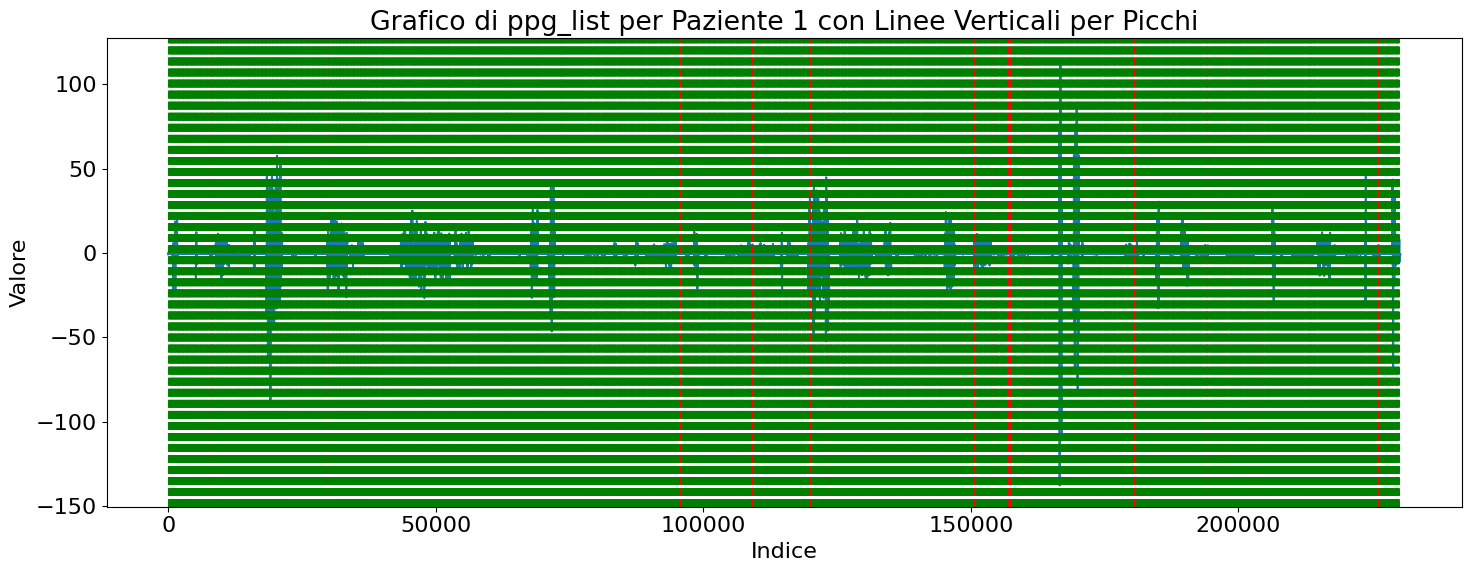

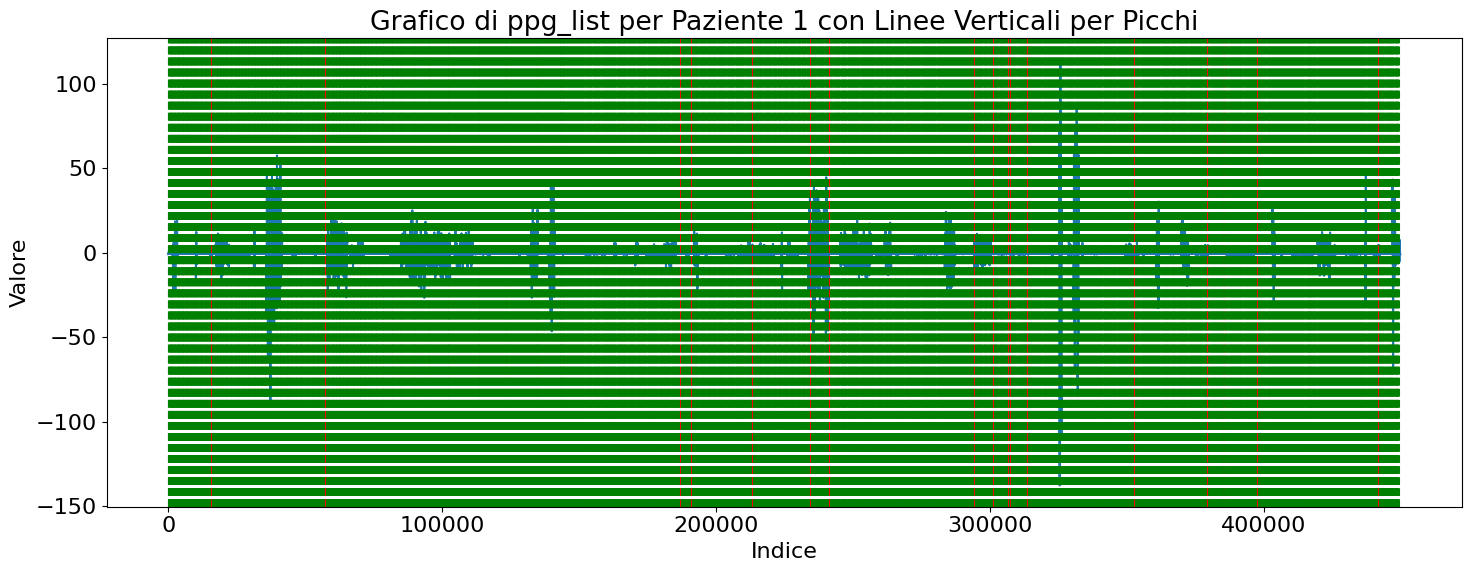

In [ ]:
start_example = 0
length = 230270
patient_index_example = 1
plot_patient_data(start_example,length, patient_index_example, ppg_list_128, ppg_list_128_speaks, ppg_list_128_ann)

start_example = 0
length = 449746
patient_index_example = 1
plot_patient_data(start_example, length, patient_index_example, interpolated_ppg_128_list, updated_speaks_128_list, ppg_list_128_ann)

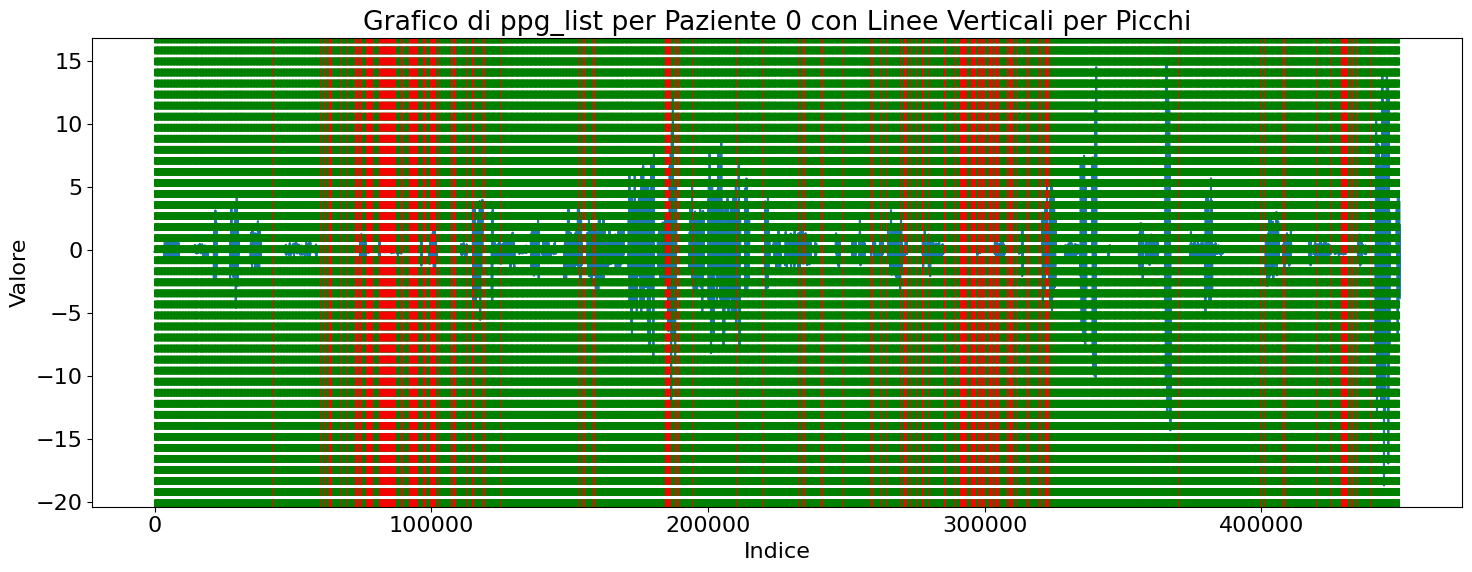

In [ ]:
start_example = 0
patient_index_example = 0
length = len(ppg_list_250[patient_index_example])

plot_patient_data(start_example, length,patient_index_example, ppg_list_250, ppg_list_250_speaks, ppg_list_250_ann)

UNISCO TUTTI I PAZIENTI (ORA TUTTI A 250Hz)

In [ ]:
ppg_list_ann = ppg_list_128_ann + ppg_list_250_ann
ppg_list = interpolated_ppg_128_list + ppg_list_250
ppg_list_speaks = updated_speaks_128_list + ppg_list_250_speaks

print(len(ppg_list_ann))
print(len(ppg_list))
print(len(ppg_list_speaks))

103
103
103


## Basic Data Visualization

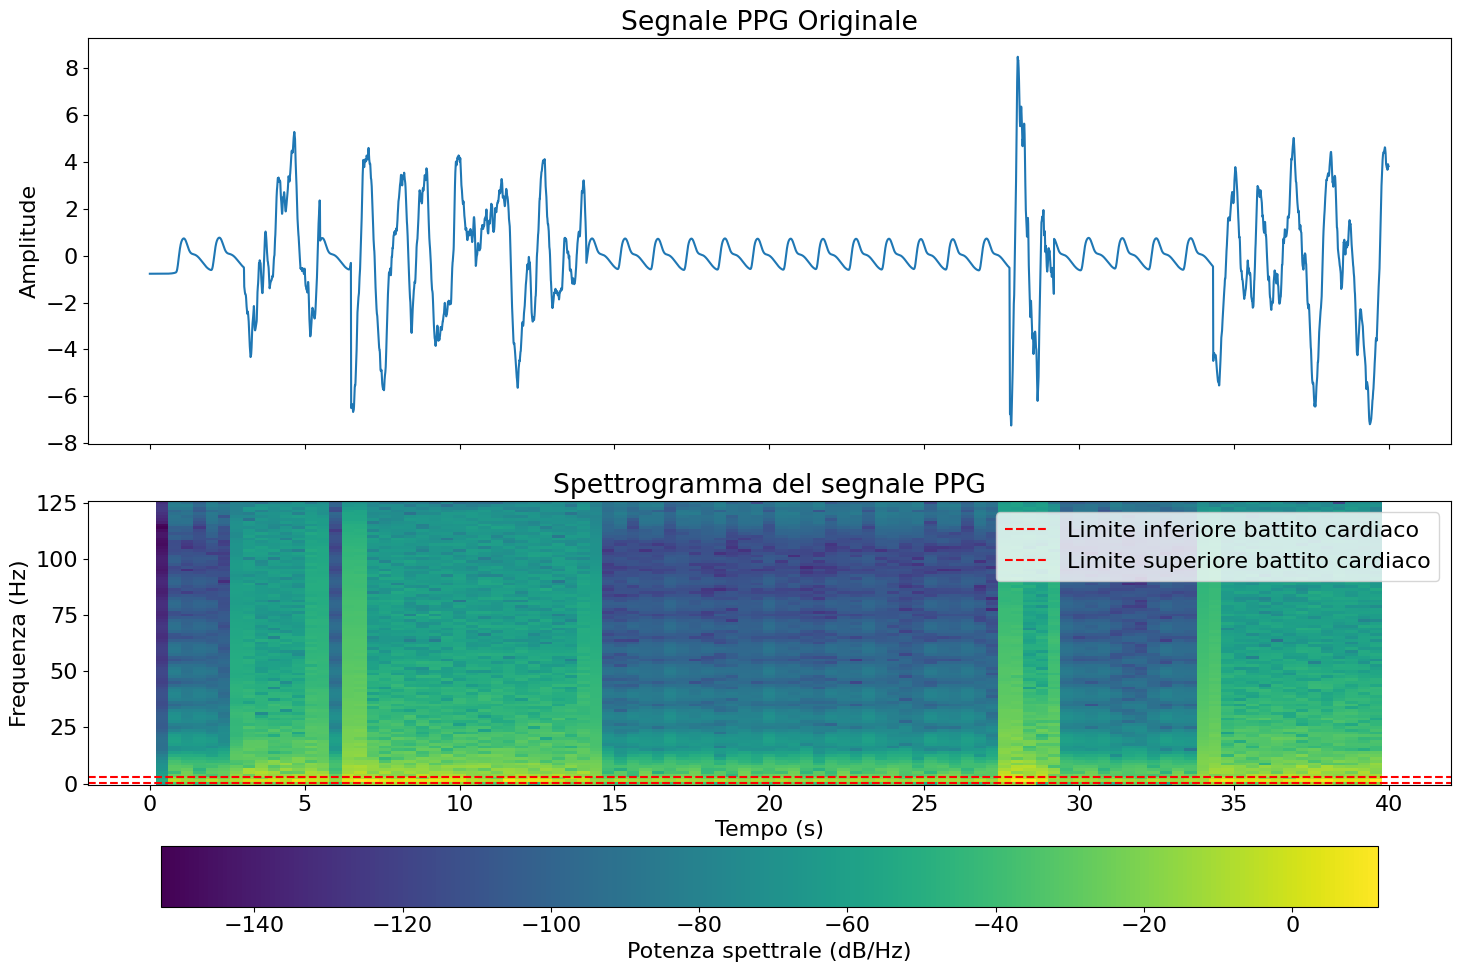

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Sostituisci questa lista con i dati del tuo paziente
ppg_data = np.array(ppg_list[0][:10000], dtype=np.float64)

# Parametri per la STFT
fs = 250  # Frequenza di campionamento (Hz)
nperseg = 200  # Numero di campioni per ogni segmento (lunghezza del battito)
noverlap = 100  # Sovrapposizione tra segmenti

# Calcola la STFT
frequencies, times, spectrogram_data = spectrogram(ppg_data, fs=fs, nperseg=nperseg, noverlap=noverlap)

# Converti gli indici in secondi
time_seconds = np.arange(len(ppg_data)) / fs

# Imposta la dimensione della figura
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot del segnale PPG originale con l'asse x in secondi
axs[0].plot(time_seconds, ppg_data)
axs[0].set_title('Segnale PPG Originale')
axs[0].set_ylabel('Amplitude')

# Plot dello spettrogramma
img = axs[1].pcolormesh(times, frequencies, 10 * np.log10(spectrogram_data), shading='auto')
axs[1].set_title('Spettrogramma del segnale PPG')
axs[1].set_xlabel('Tempo (s)')
axs[1].set_ylabel('Frequenza (Hz)')

# Aggiungi la legenda dei colori
cbar = plt.colorbar(img, ax=axs[1], orientation='horizontal' ,label='Potenza spettrale (dB/Hz)')

# Regola la disposizione dei subplots per evitare sovrapposizioni
plt.tight_layout()

# Individua il battito cardiaco (ipotetico intervallo tra 0.5 e 3 Hz)
plt.axhline(y=0.5, color='r', linestyle='--', label='Limite inferiore battito cardiaco')
plt.axhline(y=3, color='r', linestyle='--', label='Limite superiore battito cardiaco')
plt.legend()

plt.show()


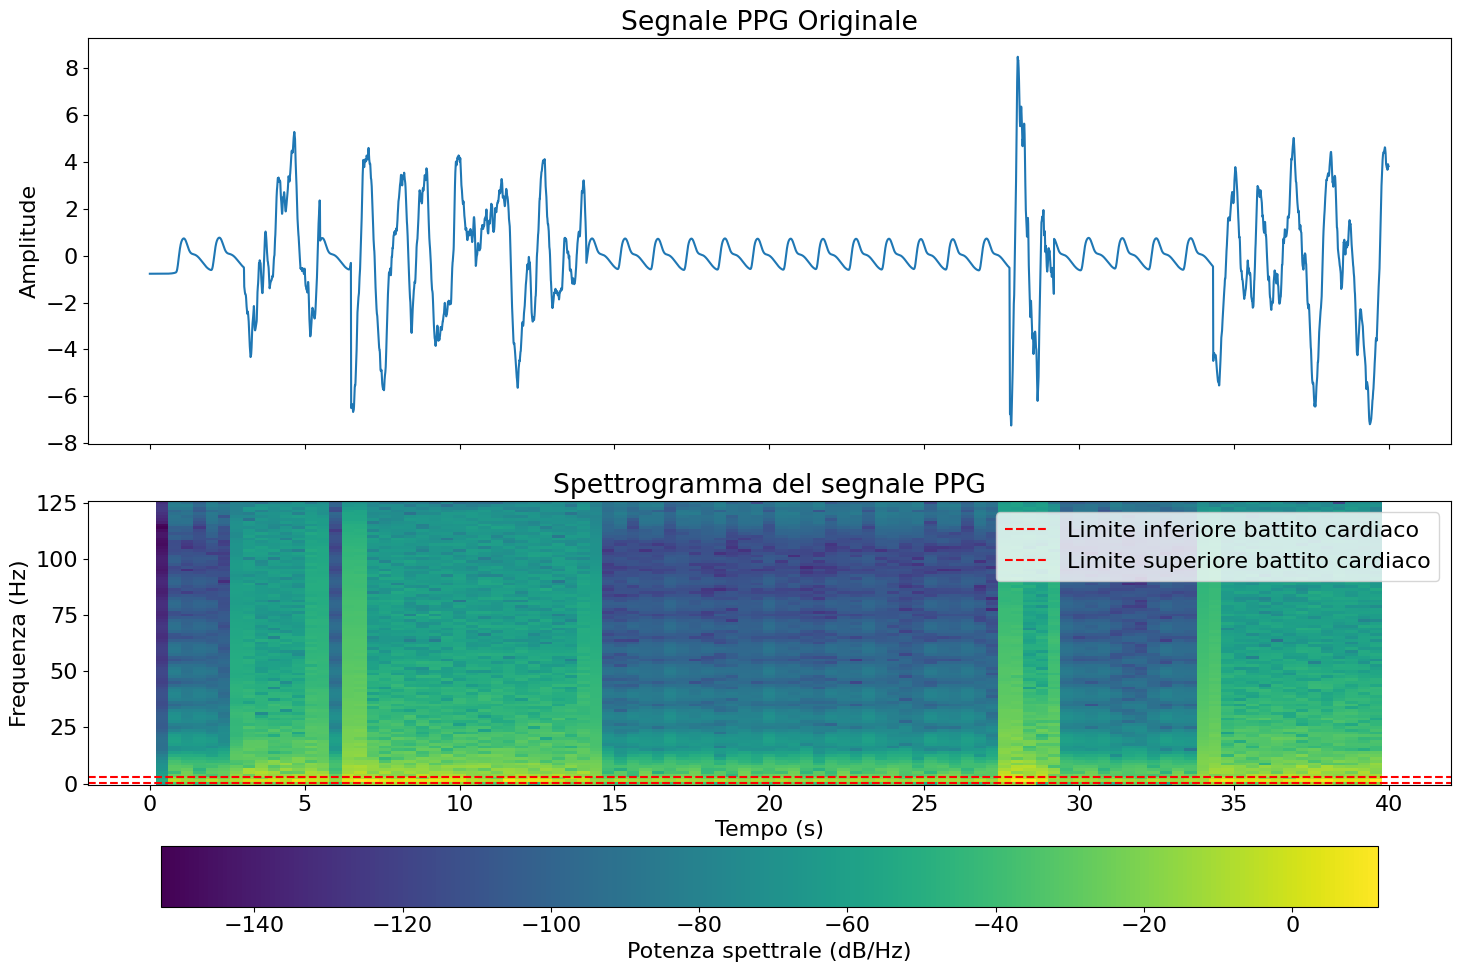

(array([  0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,
         10.  ,  11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,
         20.  ,  21.25,  22.5 ,  23.75,  25.  ,  26.25,  27.5 ,  28.75,
         30.  ,  31.25,  32.5 ,  33.75,  35.  ,  36.25,  37.5 ,  38.75,
         40.  ,  41.25,  42.5 ,  43.75,  45.  ,  46.25,  47.5 ,  48.75,
         50.  ,  51.25,  52.5 ,  53.75,  55.  ,  56.25,  57.5 ,  58.75,
         60.  ,  61.25,  62.5 ,  63.75,  65.  ,  66.25,  67.5 ,  68.75,
         70.  ,  71.25,  72.5 ,  73.75,  75.  ,  76.25,  77.5 ,  78.75,
         80.  ,  81.25,  82.5 ,  83.75,  85.  ,  86.25,  87.5 ,  88.75,
         90.  ,  91.25,  92.5 ,  93.75,  95.  ,  96.25,  97.5 ,  98.75,
        100.  , 101.25, 102.5 , 103.75, 105.  , 106.25, 107.5 , 108.75,
        110.  , 111.25, 112.5 , 113.75, 115.  , 116.25, 117.5 , 118.75,
        120.  , 121.25, 122.5 , 123.75, 125.  ]),
 array([[1.25236249e-06, 4.88274825e-04, 4.35813441e-03, ...,
         9.00840702e-03,

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

def visualizza_spettrogramma(ppg_data, fs=250, nperseg=200, noverlap=100):
    # Calcola la STFT
    frequencies, times, spectrogram_data = spectrogram(ppg_data, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Converti gli indici in secondi
    time_seconds = np.arange(len(ppg_data)) / fs

    # Imposta la dimensione della figura
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Plot del segnale PPG originale con l'asse x in secondi
    axs[0].plot(time_seconds, ppg_data)
    axs[0].set_title('Segnale PPG Originale')
    axs[0].set_ylabel('Amplitude')

    # Plot dello spettrogramma
    img = axs[1].pcolormesh(times, frequencies, 10 * np.log10(spectrogram_data), shading='auto')
    axs[1].set_title('Spettrogramma del segnale PPG')
    axs[1].set_xlabel('Tempo (s)')
    axs[1].set_ylabel('Frequenza (Hz)')

    # Aggiungi la legenda dei colori
    cbar = plt.colorbar(img, ax=axs[1], orientation='horizontal', label='Potenza spettrale (dB/Hz)')

    # Regola la disposizione dei subplots per evitare sovrapposizioni
    plt.tight_layout()

    # Individua il battito cardiaco (ipotetico intervallo tra 0.5 e 3 Hz)
    axs[1].axhline(y=0.5, color='r', linestyle='--', label='Limite inferiore battito cardiaco')
    axs[1].axhline(y=3, color='r', linestyle='--', label='Limite superiore battito cardiaco')
    axs[1].legend()

    plt.show()

    return frequencies,spectrogram_data

# Esempio di utilizzo
ppg_data = ppg_list[0][:10000]
visualizza_spettrogramma(ppg_data)


In [ ]:
from scipy.signal import butter, lfilter, filtfilt

def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """
        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

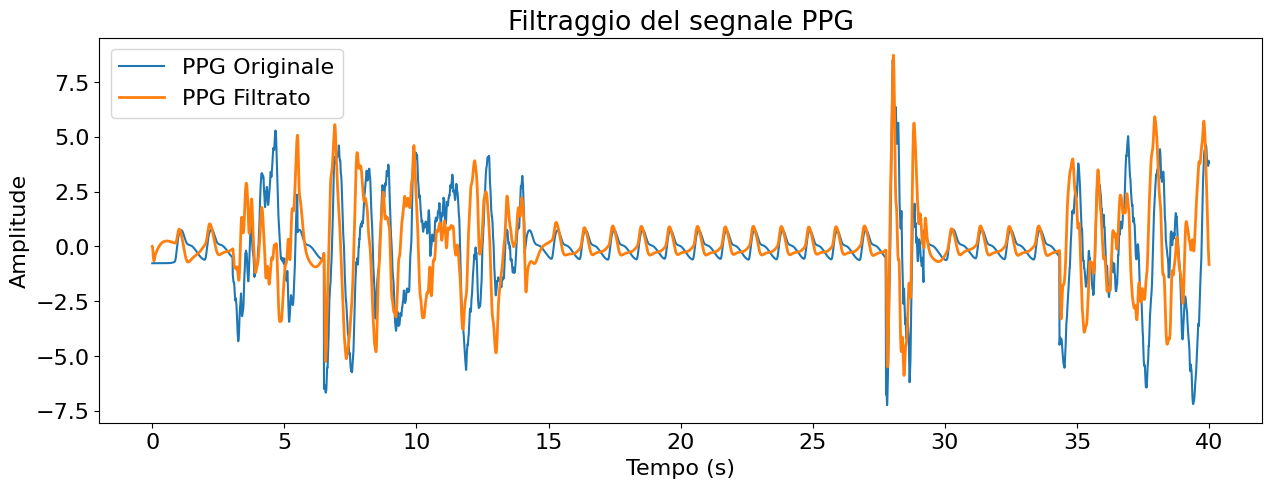

In [ ]:
# **********DA TOGLIERE, SEMBRA INUTILE *******************
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Sostituisci questa lista con i dati del tuo paziente
ppg_data = ppg_list[0][:10000]



# Filtra il segnale PPG
ppg_filtered = bandpass_filter(ppg_data, 0.5, 10, 250, 3)


# Converti gli indici in secondi
time_seconds = np.arange(len(ppg_data)) / fs

# Imposta la dimensione della figura
plt.figure(figsize=(15, 5))

# Plot del segnale PPG originale con l'asse x in secondi
plt.plot(time_seconds, ppg_data, label='PPG Originale')
plt.plot(time_seconds, ppg_filtered, label='PPG Filtrato', linewidth=2)
plt.title('Filtraggio del segnale PPG')
plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.show()


In [ ]:
def plot_patient_data(start,length, patient_index, ppg_list, ppg_list_speaks, ppg_list_ann):
    end = start + length

    # Creare un array di indici per la serie ppg_list
    indici = np.arange(start, end)

    # Creazione del grafico
    plt.figure(figsize=(15, 6))  # Imposta la larghezza della figura

    plt.plot(indici, ppg_list[patient_index][start:end], label='ppg_list')

    # Aggiungi linee verticali in corrispondenza dei valori in ppg_list_speaks
    for peak, category in zip(ppg_list_speaks[patient_index], ppg_list_ann[patient_index]):
        if start < peak < end:
            linestyle = '--'
            label = 'Picco'

            # Imposta il colore in base alla categoria del picco
            if category == 'N':
                color = 'green'
            elif category == 'S':
                color = 'red'
            elif category == 'V':
                color = 'purple'
            else:
                color = 'blue'  # Imposta un colore di default se la categoria non è N, S o V

            plt.axvline(x=peak, color=color, linestyle=linestyle, label=label)

    # Aggiungi titoli e etichette se necessario
    plt.title(f'Grafico di ppg_list per Paziente {patient_index} con Linee Verticali per Picchi')
    plt.xlabel('Indice')
    plt.ylabel('Valore')

    # Aggiungi la legenda
    #plt.legend(prop={'size': 6})

    # Rendi il grafico interattivo
    plt.tight_layout()
    plt.show()

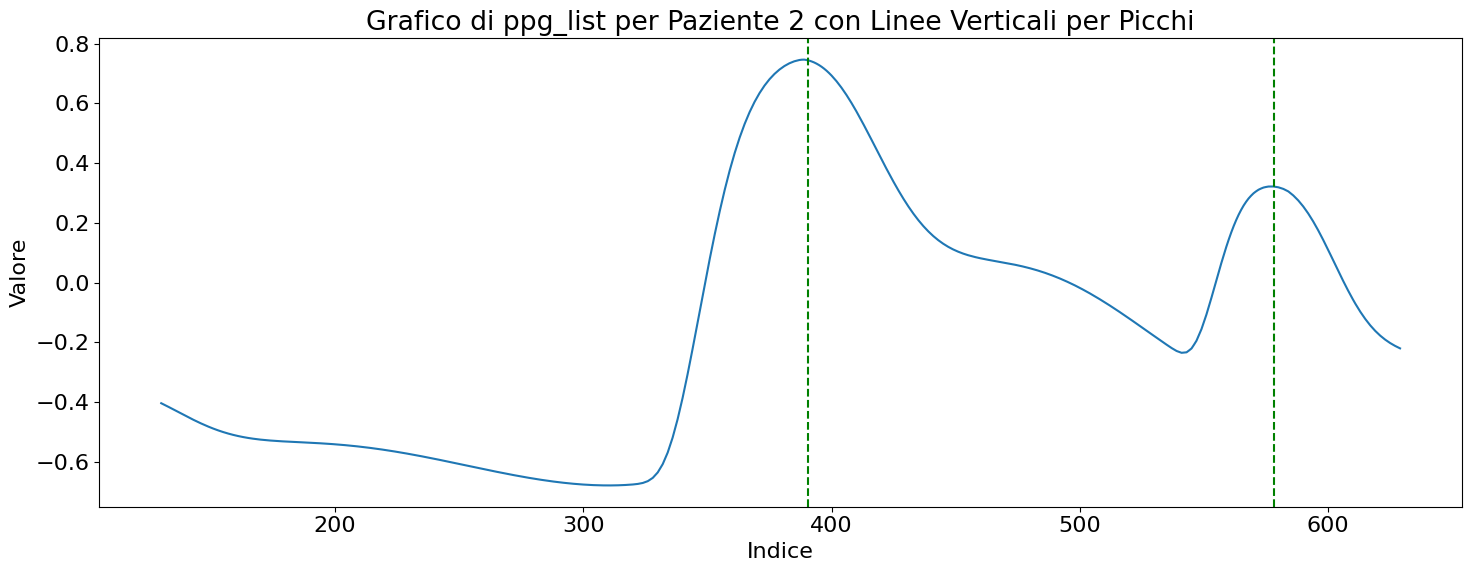

In [ ]:
# Esempio di chiamata alla funzione
start_example = 130
patient_index_example = 2
plot_patient_data(start_example, 500, patient_index_example, ppg_list, ppg_list_speaks, ppg_list_ann)

Counter({'N': 226448, 'S': 9691, 'V': 7994})


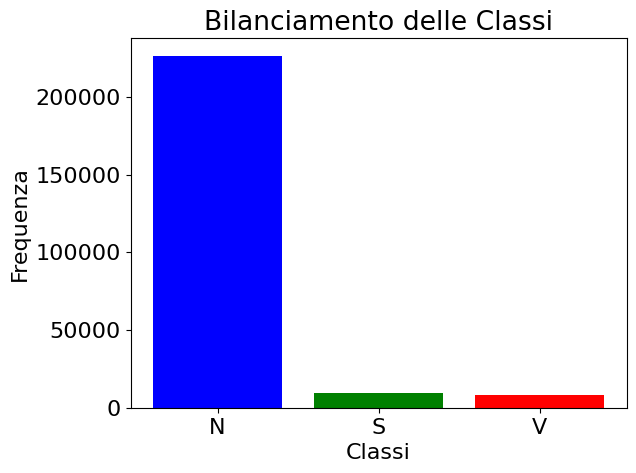

{'N': 92.7559977553219, 'S': 3.9695575772222518, 'V': 3.2744446674558536}


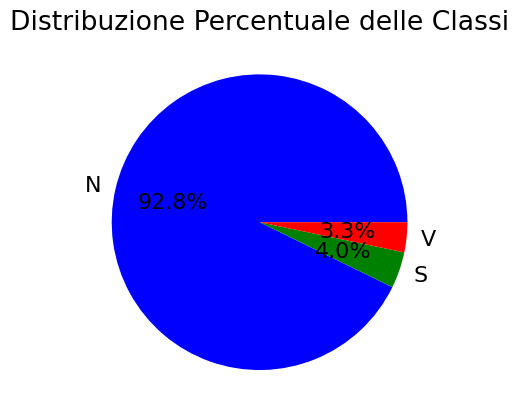

In [ ]:
#DATA VISUALIZATION PER TUTTE LE LABEL DEI PAZIENTI MESSE INSIEME

from collections import Counter

#CONTEGGIO ETICHETTE:
# ppg_list_ann è la lista di array contenenti le etichette
flat_list = [label for arr in ppg_list_ann for label in arr]
counts = Counter(flat_list)
print(counts)

#GRAFICO A BARRE:
labels, values = zip(*counts.items())
plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Bilanciamento delle Classi')
plt.show()

#PERCENTUALI DI OGNI CLASSE
total_samples = len(flat_list)
percentages = {label: count / total_samples * 100 for label, count in counts.items()}

print(percentages)

# Percentuali delle classi
labels, values = zip(*percentages.items())

# Creazione del grafico a torta
plt.pie(values, labels=labels, autopct='%1.1f%%', colors=['blue', 'green', 'red'])

# Aggiungi un titolo
plt.title('Distribuzione Percentuale delle Classi')

# Mostra il grafico
plt.show()

103


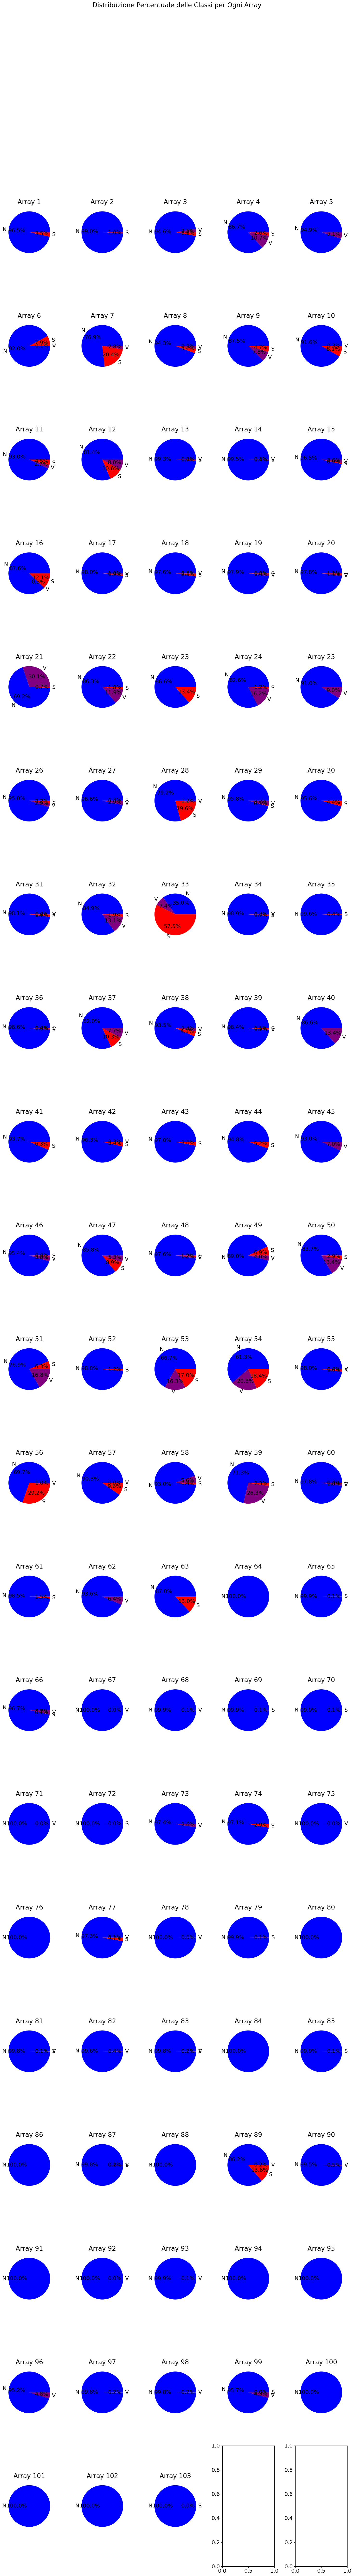

In [ ]:
#DATA VISUALIZATION PER OGNI SEGNALE (ognuno dei 105 pazienti)
# ppg_list_ann è la  lista di array contenenti le etichette
num_arrays = len(ppg_list_ann)
print(num_arrays)
# Calcola il numero di righe e colonne per la griglia di subplot (5 colonne per ogni riga)
num_rows = (num_arrays // 5) + (num_arrays % 5 > 0)
num_cols = min(num_arrays, 5)

# Creazione di subplot multipli
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.suptitle('Distribuzione Percentuale delle Classi per Ogni Array', y=1.02)

# Colori per le classi
colors = {'N': 'blue', 'S': 'red', 'V': 'purple'}

# Itera attraverso gli array e crea un grafico a torta per ciascuno
for i, arr in enumerate(ppg_list_ann):
    counts = Counter(arr)
    labels, values = zip(*counts.items())

    # Calcola la posizione del subplot nella griglia
    row_idx, col_idx = divmod(i, num_cols)

    # Calcola i rect per il layout
    rect = [col_idx / num_cols, 1 - (row_idx + 1) / num_rows, 1 / num_cols, 1 / num_rows]

    # Crea il grafico a torta nel subplot corrispondente
    ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
    ax.pie(values, labels=labels, autopct='%1.1f%%', colors=[colors[label] for label in labels])
    ax.set_title(f'Array {i+1}')

# Regola la disposizione dei subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Mostra il grafico
plt.show()



In [ ]:
distances = np.diff(ppg_list_speaks[0].flatten())
print(len(ppg_list_speaks[0]))
print(distances[:30])

1706
[287.109375 273.4375   281.25     277.34375  277.34375  277.34375
 271.484375 269.53125  273.4375   273.4375   259.765625 275.390625
 267.578125 263.671875 269.53125  271.484375 263.671875 267.578125
 259.765625 267.578125 265.625    257.8125   257.8125   271.484375
 269.53125  269.53125  285.15625  273.4375   273.4375   277.34375 ]


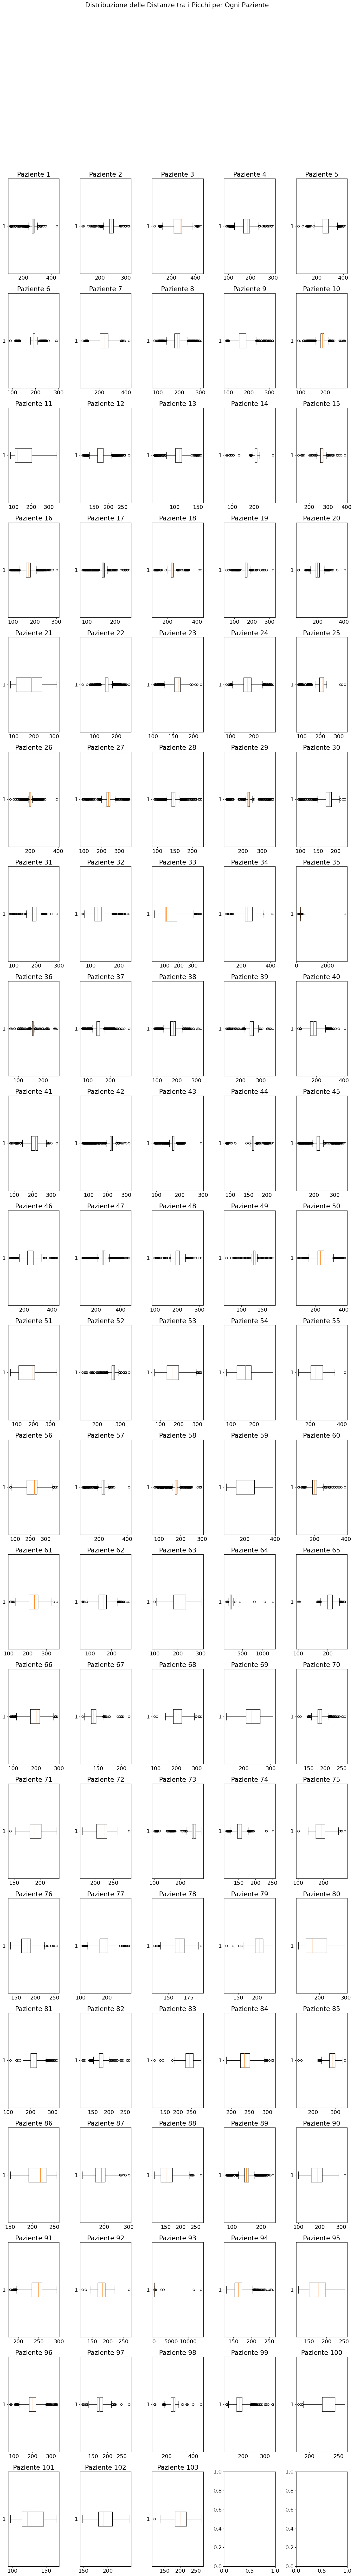

In [ ]:
# Creazione di subplot multipli per i boxplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.suptitle('Distribuzione delle Distanze tra i Picchi per Ogni Paziente', y=1.02)

# Itera attraverso gli array di picchi e crea un boxplot per ciascuno
for i, peaks_array in enumerate(ppg_list_speaks):
    # Calcola le distanze tra i picchi
    distances = np.diff(peaks_array.flatten())
    # Calcola la posizione del subplot nella griglia
    row_idx, col_idx = divmod(i, num_cols)

    # Calcola i rect per il layout
    rect = [col_idx / num_cols, 1 - (row_idx + 1) / num_rows, 1 / num_cols, 1 / num_rows]

    # Crea il boxplot nel subplot corrispondente
    ax = axes[row_idx, col_idx] if num_rows > 1 else axes[col_idx]
    ax.boxplot(distances, vert=False)
    ax.set_title(f'Paziente {i+1}')

# Regola la disposizione dei subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Mostra il grafico
plt.show()

## CREATE DATASET

###SPLIT PATIENTS (train/val/test)

SPLIT IN TRAIN/VAL/TEST CERCANDO DI DIVIDERE I PAZIENTI, IN MODO DA PRESERVARE PIU O MENO LA DISTRIBUZIONE:



1.   Calcola la distribuzione delle label per ogni paziente.
2.   Ordina i pazienti in base alla loro distribuzione di label.
3.   Dividi i pazienti in train, val e test in base al rapporto desiderato





In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split

# Supponiamo che ppg_list_ann sia una lista di liste di label, una lista per paziente
# Inserisci il tuo codice per ottenere ppg_list_ann

# Calcola la distribuzione delle label per ogni paziente
label_distributions = [Counter(arr) for arr in ppg_list_ann]

# Ottieni l'elenco di pazienti e le rispettive distribuzioni di label
patients, distributions = zip(*enumerate(label_distributions))

# Ordina i pazienti in base alle loro distribuzioni di label
sorted_patients = [x for _, x in sorted(zip(distributions, patients), key=lambda pair: sum(pair[0].values()), reverse=True)]

# Definisci i rapporti di divisione per train, val, test (ad esempio, 70%, 15%, 15%)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calcola le dimensioni dei set di allenamento, validazione e test
num_patients = len(sorted_patients)
num_train = int(train_ratio * num_patients)
num_val = int(val_ratio * num_patients)

# Dividi i pazienti
train_patients, remaining_patients = sorted_patients[:num_train], sorted_patients[num_train:]
val_patients, test_patients = remaining_patients[:num_val], remaining_patients[num_val:]

# Verifica la distribuzione delle label nei set di allenamento, validazione e test
train_label_distribution = Counter(label for patient in train_patients for label in ppg_list_ann[patient])
val_label_distribution = Counter(label for patient in val_patients for label in ppg_list_ann[patient])
test_label_distribution = Counter(label for patient in test_patients for label in ppg_list_ann[patient])

print("Distribuzione delle label nel set di allenamento:", train_label_distribution)
print("Distribuzione delle label nel set di validazione:", val_label_distribution)
print("Distribuzione delle label nel set di test:", test_label_distribution)


Distribuzione delle label nel set di allenamento: Counter({'N': 171564, 'S': 8504, 'V': 6451})
Distribuzione delle label nel set di validazione: Counter({'N': 27389, 'V': 1140, 'S': 817})
Distribuzione delle label nel set di test: Counter({'N': 27495, 'V': 403, 'S': 370})


In [ ]:
print(train_patients)
print(val_patients)
print(test_patients)

[12, 31, 100, 48, 66, 32, 27, 36, 88, 10, 73, 87, 16, 21, 22, 35, 53, 61, 43, 77, 93, 18, 8, 52, 50, 15, 42, 23, 11, 96, 57, 94, 81, 37, 75, 29, 39, 3, 91, 69, 98, 9, 20, 86, 89, 79, 74, 30, 76, 70, 5, 7, 65, 101, 24, 102, 59, 25, 47, 95, 67, 78, 19, 13, 64, 62, 41, 55, 40, 85, 80, 71]
[44, 58, 56, 63, 68, 28, 6, 60, 99, 17, 49, 26, 54, 83, 92]
[82, 1, 97, 90, 45, 34, 72, 33, 38, 2, 0, 46, 14, 51, 4, 84]


In [ ]:
# Dividi ppg_list
train_ppg_list = [ppg_list[i] for i in train_patients]
val_ppg_list = [ppg_list[i] for i in val_patients]
test_ppg_list = [ppg_list[i] for i in test_patients]

# Dividi ppg_list_speaks
train_ppg_list_speaks = [ppg_list_speaks[i] for i in train_patients]
val_ppg_list_speaks = [ppg_list_speaks[i] for i in val_patients]
test_ppg_list_speaks = [ppg_list_speaks[i] for i in test_patients]

# Dividi ppg_list_ann
train_ppg_list_ann = [ppg_list_ann[i] for i in train_patients]
val_ppg_list_ann = [ppg_list_ann[i] for i in val_patients]
test_ppg_list_ann = [ppg_list_ann[i] for i in test_patients]

# Verifica le dimensioni dei set di segnali e notazioni dei picchi
print("Dimensione del set di allenamento (patients):", len(train_patients))
print("Dimensione del set di validazione (patients):", len(val_patients))
print("Dimensione del set di test (patients):", len(test_patients))

print("Dimensione del set di allenamento (label):", len(train_ppg_list_ann))
print("Dimensione del set di validazione (label):", len(val_ppg_list_ann))
print("Dimensione del set di test (label):", len(test_ppg_list_ann))

print("Dimensione del set di allenamento (ppg_list):", len(train_ppg_list))
print("Dimensione del set di validazione (ppg_list):", len(val_ppg_list))
print("Dimensione del set di test (ppg_list):", len(test_ppg_list))

print("Dimensione del set di allenamento (ppg_list_speaks):", len(train_ppg_list_speaks))
print("Dimensione del set di validazione (ppg_list_speaks):", len(val_ppg_list_speaks))
print("Dimensione del set di test (ppg_list_speaks):", len(test_ppg_list_speaks))


Dimensione del set di allenamento (patients): 72
Dimensione del set di validazione (patients): 15
Dimensione del set di test (patients): 16
Dimensione del set di allenamento (label): 72
Dimensione del set di validazione (label): 15
Dimensione del set di test (label): 16
Dimensione del set di allenamento (ppg_list): 72
Dimensione del set di validazione (ppg_list): 15
Dimensione del set di test (ppg_list): 16
Dimensione del set di allenamento (ppg_list_speaks): 72
Dimensione del set di validazione (ppg_list_speaks): 15
Dimensione del set di test (ppg_list_speaks): 16


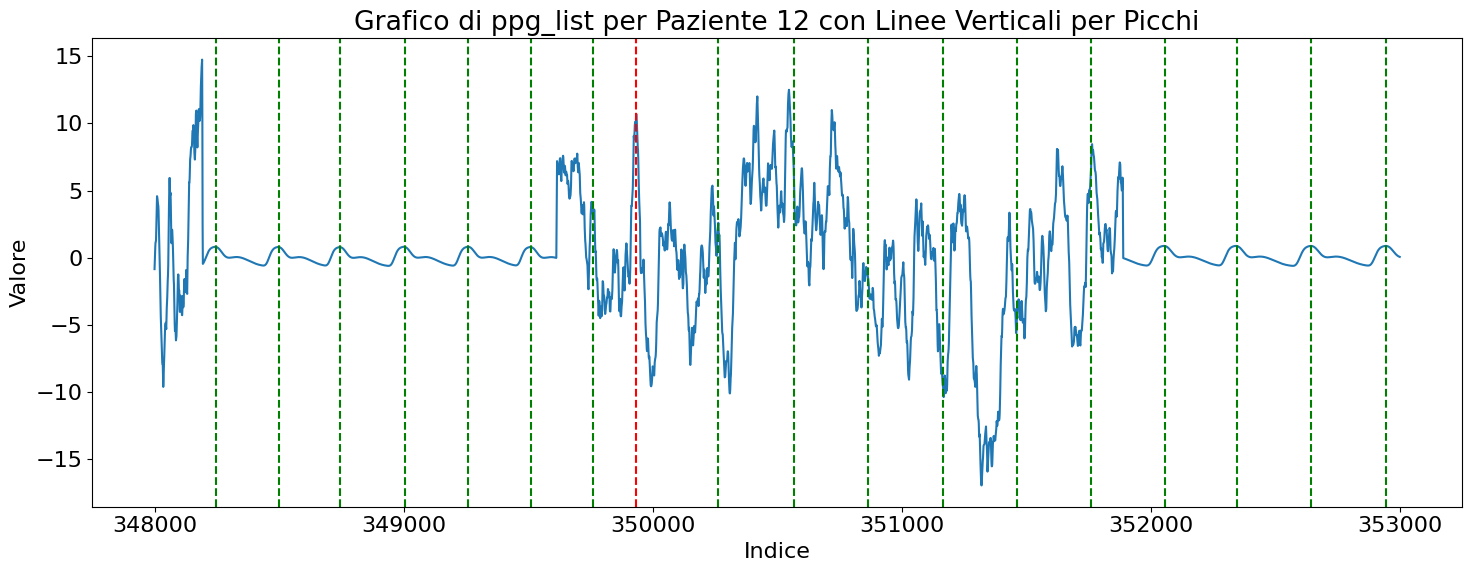

In [ ]:
start_example = 348000
patient_index_example = 12
length = 5000 #len(train_ppg_list[patient_index_example])

plot_patient_data(start_example, length,patient_index_example, val_ppg_list, val_ppg_list_speaks, val_ppg_list_ann)

In [ ]:
def calculate_average_lengths(peaks_list, labels_list):
    if len(peaks_list) != len(labels_list):
        raise ValueError("Length of peaks and labels must be the same")

    result = {'N': [], 'S': [], 'V': []}

    for peaks, labels in zip(peaks_list, labels_list):
        for i in range(1, len(peaks)-1):
            peak = peaks[i]
            label = labels[i]

            previous_peak = peaks[i - 1]
            next_peak = peaks[i + 1]
            lenght = next_peak - previous_peak
            if lenght < 0 or lenght > 1000:
                continue
            result[label].append(lenght)

    average_lengths = {label: sum(lengths) / len(lengths) if lengths else 0 for label, lengths in result.items()}

    return average_lengths

average_lengths = calculate_average_lengths(train_ppg_list_speaks, train_ppg_list_ann)
print(average_lengths)

{'N': array([351.11854299]), 'S': array([288.4187386]), 'V': array([318.46443154])}


### ESTRAI BEAT (scarta rumore)

In [ ]:
def is_noise_check(segnale, fs=250, nperseg=400, noverlap=0, soglia_alte_frequenze=5, soglia_rumore=0.1):
    frequencies, _,spectr_data = spectrogram(segnale, fs=fs, nperseg=nperseg, noverlap=noverlap)

    # Calcola la somma della potenza nelle alte frequenze
    potenza_alte_frequenze_battito = np.sum(spectr_data[frequencies > soglia_alte_frequenze, :])

    # Classifica il battito in base alla soglia
    rumore = potenza_alte_frequenze_battito > soglia_rumore

    # if rumore:
    #   print('This signal is noisy.')
    return rumore

In [ ]:
WINDOW_SIZE = 400

def extract_beats(ppg_list, ppg_list_speaks, ppg_list_ann, window_size=WINDOW_SIZE, peak_ratio=0.5):   # peak_ratio represent how much of the signal is before and after the peak
    all_beats = []
    all_labels = []

    for signals, peaks, labels in zip(ppg_list, ppg_list_speaks, ppg_list_ann):
        beats = []
        beat_labels = []
        len_sig = signals.shape[0]

        for idx, peak_pos_label in enumerate(zip(peaks, labels)):
            peak_pos, label = peak_pos_label
            # Calcola la lunghezza del battito
            window_size = int(window_size)

            # Calcola la posizione del picco nel battito
            peak_position_in_beat = int(window_size * peak_ratio)

            # Calcola la finestra temporale per estrarre il battito
            window_start = int(peak_pos - peak_position_in_beat)
            window_end = int(window_start + window_size)
            previous_peak = peaks[idx-1] if idx>0 else 0
            next_peak = peaks[idx+1] if idx<len(peaks)-1 else len_sig-1

            start = max(0, window_start, int(previous_peak))   #window_start if window_start > 0 else 0
            end = min(len_sig-1, window_end, int(next_peak))   #window_end if window_end < len_sig else len_sig

            # Estrai il battito dalla finestra temporale
            beat = signals[start:end]

            beats.append(beat.flatten())
            beat_labels.append(label)

        all_beats.extend(beats)
        all_labels.extend(beat_labels)

    return all_beats, all_labels

# Estrai i battiti per i set di allenamento, validazione e test
train_beats, train_beats_labels = extract_beats(train_ppg_list, train_ppg_list_speaks, train_ppg_list_ann)
val_beats, val_beats_labels = extract_beats(val_ppg_list, val_ppg_list_speaks, val_ppg_list_ann)
test_beats, test_beats_labels = extract_beats(test_ppg_list, test_ppg_list_speaks, test_ppg_list_ann)

train_beats = pad_sequences(train_beats, maxlen=WINDOW_SIZE, dtype='float32', truncating='post', padding="post")
val_beats = pad_sequences(val_beats, maxlen=WINDOW_SIZE, dtype='float32', truncating='post', padding="post")
test_beats = pad_sequences(test_beats, maxlen=WINDOW_SIZE, dtype='float32', truncating='post', padding="post")

# Converti gli array di battiti in un array numpy
train_beats_array = np.array(train_beats)
val_beats_array = np.array(val_beats)
test_beats_array = np.array(test_beats)


# Verifica le dimensioni degli array di battiti e labels
print("Dimensione del set di allenamento (beats):", train_beats_array.shape)
print("Dimensione del set di validazione (beats):", val_beats_array.shape)
print("Dimensione del set di test (beats):", test_beats_array.shape)

print("Dimensione del set di allenamento (labels):", len(train_beats_labels))
print("Dimensione del set di validazione (labels):", len(val_beats_labels))
print("Dimensione del set di test (labels):", len(test_beats_labels))

Dimensione del set di allenamento (beats): (186519, 400)
Dimensione del set di validazione (beats): (29346, 400)
Dimensione del set di test (beats): (28268, 400)
Dimensione del set di allenamento (labels): 186519
Dimensione del set di validazione (labels): 29346
Dimensione del set di test (labels): 28268


In [ ]:
#CHECK PER VEDERE CHE SIANO TUTTE LUNGHE UGUALI
length_occurrences = {}

# Calcola le occorrenze delle lunghezze
for beat in train_beats_array:
    length = len(beat)
    if length in length_occurrences:
        length_occurrences[length] += 1
    else:
        length_occurrences[length] = 1

# Stampa le lunghezze e le relative occorrenze
for length, occurrences in length_occurrences.items():
    print(f"Lunghezza: {length}, Occorrenze: {occurrences}")

Lunghezza: 400, Occorrenze: 186519


### BILANCIAMENTO CLASSI (downsampling classe N)

####train

Counter({'N': 171564, 'S': 8504, 'V': 6451})


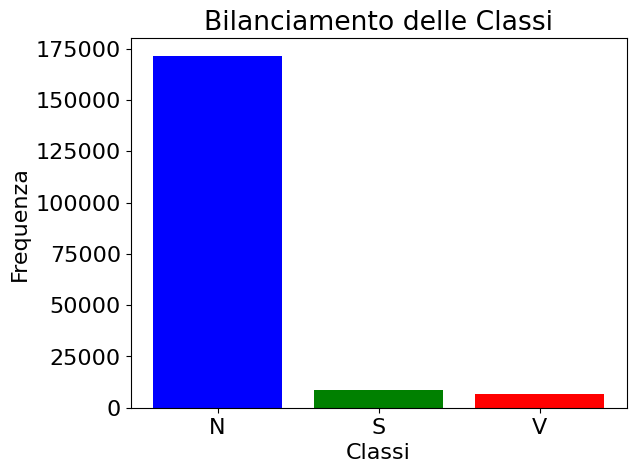

In [ ]:
#CONTEGGIO ETICHETTE TRAIN:
# train_beats_labels
flat_list = [label for arr in train_beats_labels for label in arr]
counts = Counter(flat_list)
print(counts)

#GRAFICO A BARRE:
labels, values = zip(*counts.items())
plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Bilanciamento delle Classi')
plt.show()

In [ ]:
#DOWNSAMPLING TRAIN:
data_shape = train_beats_array.shape
desired_fraction = 1/6
label_to_downsample = 'N'

# Trova gli indici degli elementi con l'etichetta specificata
indices_to_downsample = [i for i, label in enumerate(train_beats_labels) if label == label_to_downsample]

# Trova gli indici degli elementi con etichette diverse da quella specificata
indices_other_labels = [i for i, label in enumerate(train_beats_labels) if label != label_to_downsample]

# Calcola il numero di elementi da mantenere solo per l'etichetta specificata
num_elements_to_keep = int(len(indices_to_downsample) * desired_fraction)

# Genera indici casuali da mantenere solo per l'etichetta specificata
indices_to_keep = np.random.choice(indices_to_downsample, size=num_elements_to_keep, replace=False)

# Unisce gli indici da mantenere per l'etichetta specificata con quelli di altre etichette
indices_to_keep_all = list(indices_to_keep) + indices_other_labels

# Seleziona gli elementi corrispondenti agli indici generati
train_beats_array = train_beats_array[indices_to_keep_all]
train_beats_labels = [train_beats_labels[i] for i in indices_to_keep_all]

print(train_beats_array.shape)
print(len(train_beats_labels))

(43549, 400)
43549


Counter({'N': 28594, 'S': 8504, 'V': 6451})


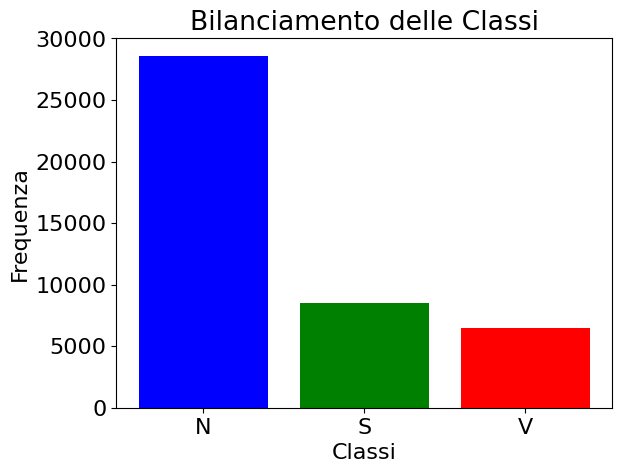

In [ ]:
#CONTEGGIO ETICHETTE TRAIN:
# train_beats_labels
flat_list = [label for arr in train_beats_labels for label in arr]
counts = Counter(flat_list)
print(counts)

#GRAFICO A BARRE:
labels, values = zip(*counts.items())
plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Bilanciamento delle Classi')
plt.show()

####val

In [ ]:
#DOWNSAMPLING VAL:
data_shape = val_beats_array.shape
desired_fraction = 1/6
label_to_downsample = 'N'

# Trova gli indici degli elementi con l'etichetta specificata
indices_to_downsample = [i for i, label in enumerate(val_beats_labels) if label == label_to_downsample]

# Trova gli indici degli elementi con etichette diverse da quella specificata
indices_other_labels = [i for i, label in enumerate(val_beats_labels) if label != label_to_downsample]

# Calcola il numero di elementi da mantenere solo per l'etichetta specificata
num_elements_to_keep = int(len(indices_to_downsample) * desired_fraction)

# Genera indici casuali da mantenere solo per l'etichetta specificata
indices_to_keep = np.random.choice(indices_to_downsample, size=num_elements_to_keep, replace=False)

# Unisce gli indici da mantenere per l'etichetta specificata con quelli di altre etichette
indices_to_keep_all = list(indices_to_keep) + indices_other_labels

# Seleziona gli elementi corrispondenti agli indici generati
val_beats_array = val_beats_array[indices_to_keep_all]
val_beats_labels = [val_beats_labels[i] for i in indices_to_keep_all]

print(val_beats_array.shape)
print(len(val_beats_labels))

(6521, 400)
6521


Counter({'N': 4564, 'V': 1140, 'S': 817})


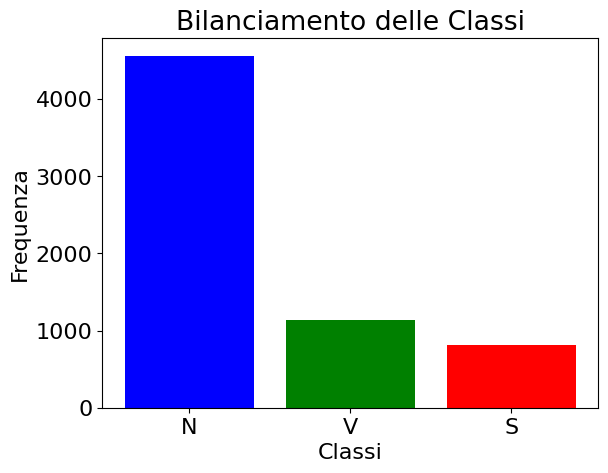

In [ ]:
#CONTEGGIO ETICHETTE TRAIN:
# train_beats_labels
flat_list = [label for arr in val_beats_labels for label in arr]
counts = Counter(flat_list)
print(counts)

#GRAFICO A BARRE:
labels, values = zip(*counts.items())
plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Bilanciamento delle Classi')
plt.show()

####test

In [ ]:
#DOWNSAMPLING TRAIN
data_shape = test_beats_array.shape
desired_fraction = 1/6
label_to_downsample = 'N'

# Trova gli indici degli elementi con l'etichetta specificata
indices_to_downsample = [i for i, label in enumerate(test_beats_labels) if label == label_to_downsample]

# Trova gli indici degli elementi con etichette diverse da quella specificata
indices_other_labels = [i for i, label in enumerate(test_beats_labels) if label != label_to_downsample]

# Calcola il numero di elementi da mantenere solo per l'etichetta specificata
num_elements_to_keep = int(len(indices_to_downsample) * desired_fraction)

# Genera indici casuali da mantenere solo per l'etichetta specificata
indices_to_keep = np.random.choice(indices_to_downsample, size=num_elements_to_keep, replace=False)

# Unisce gli indici da mantenere per l'etichetta specificata con quelli di altre etichette
indices_to_keep_all = list(indices_to_keep) + indices_other_labels

# Seleziona gli elementi corrispondenti agli indici generati
test_beats_array = test_beats_array[indices_to_keep_all]
test_beats_labels = [test_beats_labels[i] for i in indices_to_keep_all]

print(test_beats_array.shape)
print(len(test_beats_labels))

(5355, 400)
5355


Counter({'N': 4582, 'V': 403, 'S': 370})


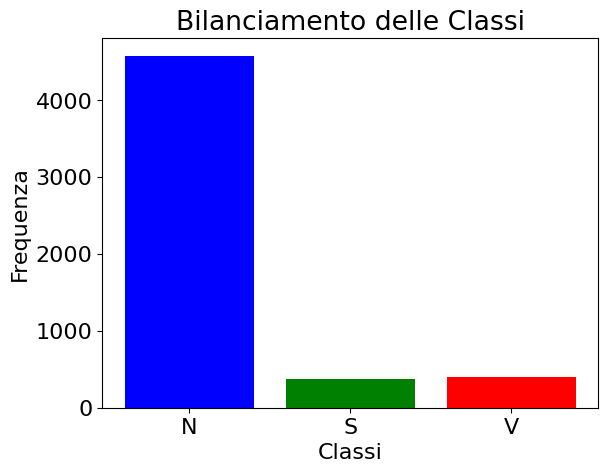

In [ ]:

#CONTEGGIO ETICHETTE TRAIN:
# train_beats_labels
flat_list = [label for arr in test_beats_labels for label in arr]
counts = Counter(flat_list)
print(counts)

#GRAFICO A BARRE:
labels, values = zip(*counts.items())
plt.bar(labels, values, color=['blue', 'green', 'red'])
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Bilanciamento delle Classi')
plt.show()

#### One-Hot encoding

In [ ]:
from tensorflow.keras.utils import to_categorical

# Mappa delle etichette a valori numerici
label_mapping = {'N': 0, 'S': 1, 'V': 2}
num_classes=3

# Converte le label in formato numerico
train_numeric_labels = [label_mapping[label] for label in train_beats_labels]
val_numeric_labels = [label_mapping[label] for label in val_beats_labels]
test_numeric_labels = [label_mapping[label] for label in test_beats_labels]

# Converte le label in formato one-hot encoding
train_beats_labels_onehot = to_categorical(train_numeric_labels, num_classes)
val_beats_labels_onehot = to_categorical(val_numeric_labels, num_classes)
test_beats_labels_onehot = to_categorical(test_numeric_labels, num_classes)

# Verifica le dimensioni degli array one-hot encoding delle label
print("Dimensione del set di allenamento (labels one-hot):", train_beats_labels_onehot.shape)
print("Dimensione del set di validazione (labels one-hot):", val_beats_labels_onehot.shape)
print("Dimensione del set di test (labels one-hot):", test_beats_labels_onehot.shape)


Dimensione del set di allenamento (labels one-hot): (43549, 3)
Dimensione del set di validazione (labels one-hot): (6521, 3)
Dimensione del set di test (labels one-hot): (5355, 3)


#### Beats with labels

N
[ 9773 14391 21711 12517 17362 14796 19061  1004  1732 28354]
S
[30363 42785 30816 36848 32919 29218 33255 41665 33449 32760]
V
[34708 36841 40920 35489 37462 40881 29576 37296 42309 38287]


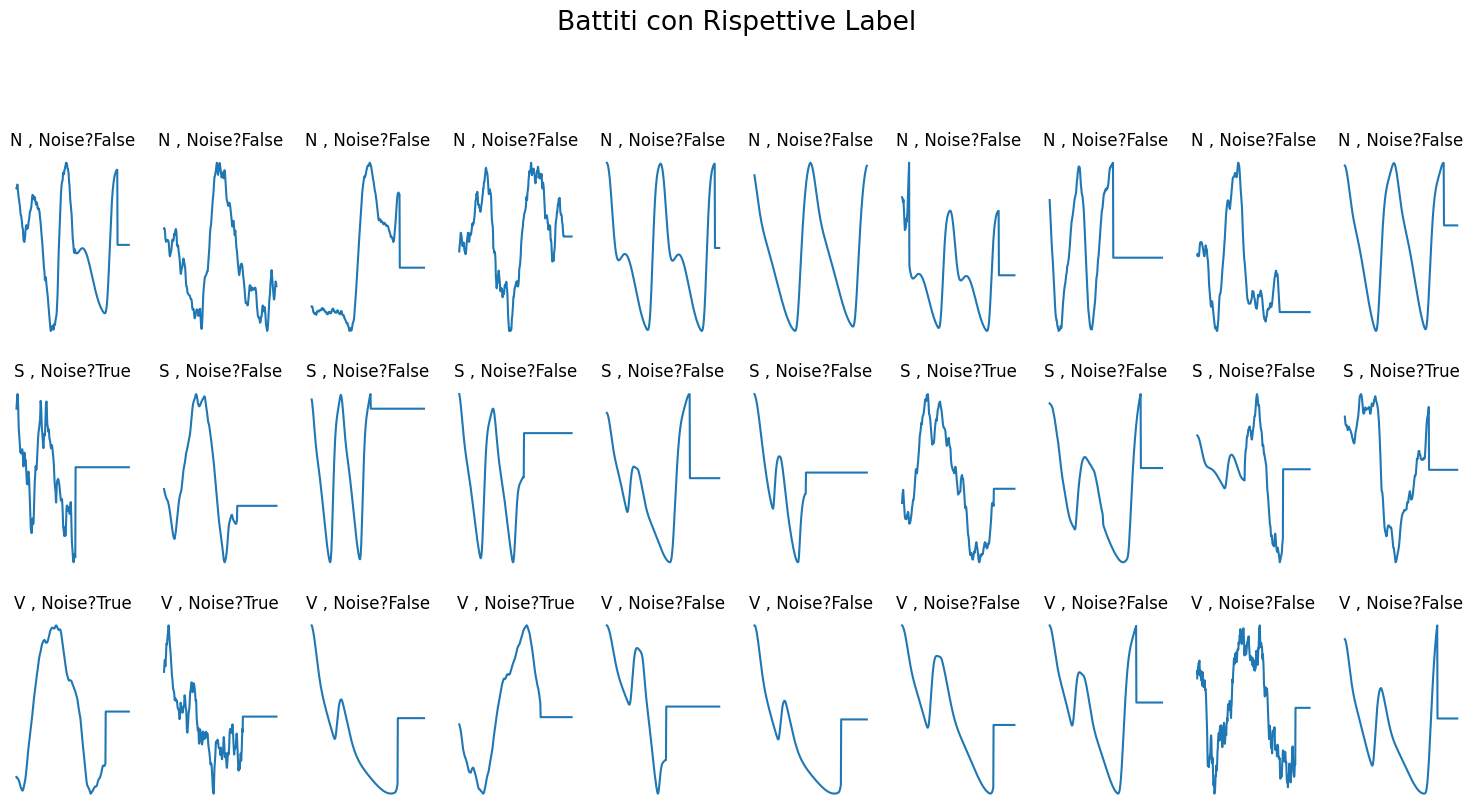

In [ ]:
# Funzione per visualizzare i battiti con le rispettive label
def plot_beats_with_labels(beats_array, labels_onehot, label_mapping, num_samples_per_class=10):
    num_classes = len(label_mapping)
    class_names = list(label_mapping.keys())

    # Creazione di una griglia di subplots
    fig, axes = plt.subplots(nrows=num_classes, ncols=num_samples_per_class, figsize=(15, 8))
    fig.suptitle('Battiti con Rispettive Label', y=1.02)

    for i, class_name in enumerate(class_names):
        # Trova gli indici dei battiti per la classe specificata
        indices = [j for j, label in enumerate(labels_onehot) if np.argmax(label) == label_mapping[class_name]]
        print(class_name)
        # Seleziona un numero specifico di campioni per la classe
        selected_indices = np.random.choice(indices, num_samples_per_class, replace=False)
        print(selected_indices)

        for j, index in enumerate(selected_indices):
            beat = beats_array[index]

            is_noise = is_noise_check(beat)
            # Plot del battito nel subplot corrispondente
            axes[i, j].plot(beat)
            axes[i, j].set_title(f'{class_name} , Noise?{is_noise}',fontsize=12)
            axes[i, j].axis('off')  # Nascondi gli assi

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualizza 10 battiti di tipo 'N', 'S' e 'V' in una griglia per il set di allenamento
plot_beats_with_labels(train_beats_array, train_beats_labels_onehot, label_mapping, num_samples_per_class=10)


### BEATS PREPROCESSING

In [ ]:
#DA TOGLIERE

#remove noise beat
def rimuovi_beat_rumore(train, labels):
    # Inizializza le liste per i segnali e le etichette senza rumore
    train_senza_rumore = []
    labels_senza_rumore = []

    # Itera su segnali e etichette utilizzando zip
    for segnale, label in zip(train, labels):
        # Verifica se il segnale è rumore usando la funzione is_noise_check
        if not is_noise_check(segnale):
            # Aggiungi il segnale e la label corrispondente alle liste senza rumore
            train_senza_rumore.append(segnale)
            labels_senza_rumore.append(label)

    # Converti le liste in array numpy
    train_senza_rumore = np.array(train_senza_rumore)
    labels_senza_rumore = np.array(labels_senza_rumore)

    return train_senza_rumore, labels_senza_rumore

# Applica la funzione alle fasi di train, val e test
train_beats_array_senza_rumore, train_beats_labels_senza_rumore = rimuovi_beat_rumore(train_beats_array, train_beats_labels_onehot)
val_beats_array_senza_rumore, val_beats_labels_senza_rumore = rimuovi_beat_rumore(val_beats_array, val_beats_labels_onehot)
test_beats_array_senza_rumore, test_beats_labels_senza_rumore = rimuovi_beat_rumore(test_beats_array, test_beats_labels_onehot)

print(train_beats_array_senza_rumore.shape)
print(train_beats_labels_senza_rumore.shape)

print(val_beats_array_senza_rumore.shape)
print(val_beats_labels_senza_rumore.shape)

print(test_beats_array_senza_rumore.shape)
print(test_beats_labels_senza_rumore.shape)

train_beats_array = train_beats_array_senza_rumore
val_beats_array = val_beats_array_senza_rumore
test_beats_array = test_beats_array_senza_rumore

train_beats_labels_onehot= train_beats_labels_senza_rumore
val_beats_labels_onehot= val_beats_labels_senza_rumore
test_beats_labels_onehot = test_beats_labels_senza_rumore

(36259, 400)
(36259, 3)
(5234, 400)
(5234, 3)
(4511, 400)
(4511, 3)


MIN-MAX TRA 0-1

In [ ]:
def min_max_normalize(data_array, *args):
    min_val = np.min(data_array)
    max_val = np.max(data_array)
    normalized_data = (data_array - min_val) / (max_val - min_val)
    return normalized_data

def get_mean_std(batched_data_array):
  data = batched_data_array.flatten()
  scaler = StandardScaler()
  scaler.fit(data.reshape(-1, 1))
  return scaler

def standardize(data_array, scaler):
  return scaler.transform(data_array.reshape(-1, 1)).squeeze(-1)

def nullnorm(data, *args):
  return data

In [ ]:
f_norm = min_max_normalize

scaler = get_mean_std(train_beats_array)

# Normalizzazione per train_beats_array
normalized_train_beats = np.array([f_norm(beat, scaler) for beat in train_beats_array])

# Normalizzazione per val_beats_array
normalized_val_beats = np.array([f_norm(beat, scaler) for beat in val_beats_array])

# Normalizzazione per test_beats_array
normalized_test_beats = np.array([f_norm(beat, scaler) for beat in test_beats_array])

print(normalized_train_beats.shape)
print(normalized_val_beats.shape)
print(normalized_test_beats.shape)

(36259, 400)
(5234, 400)
(4511, 400)


N
[ 130  231  764 1574  662 2521 2361  527  553 2858]
S
[4035 4302 4205 4433 3960 4167 4216 4094 4149 4435]
V
[4387 4328 4003 4419 4481 3971 4331 4412 4341 4024]


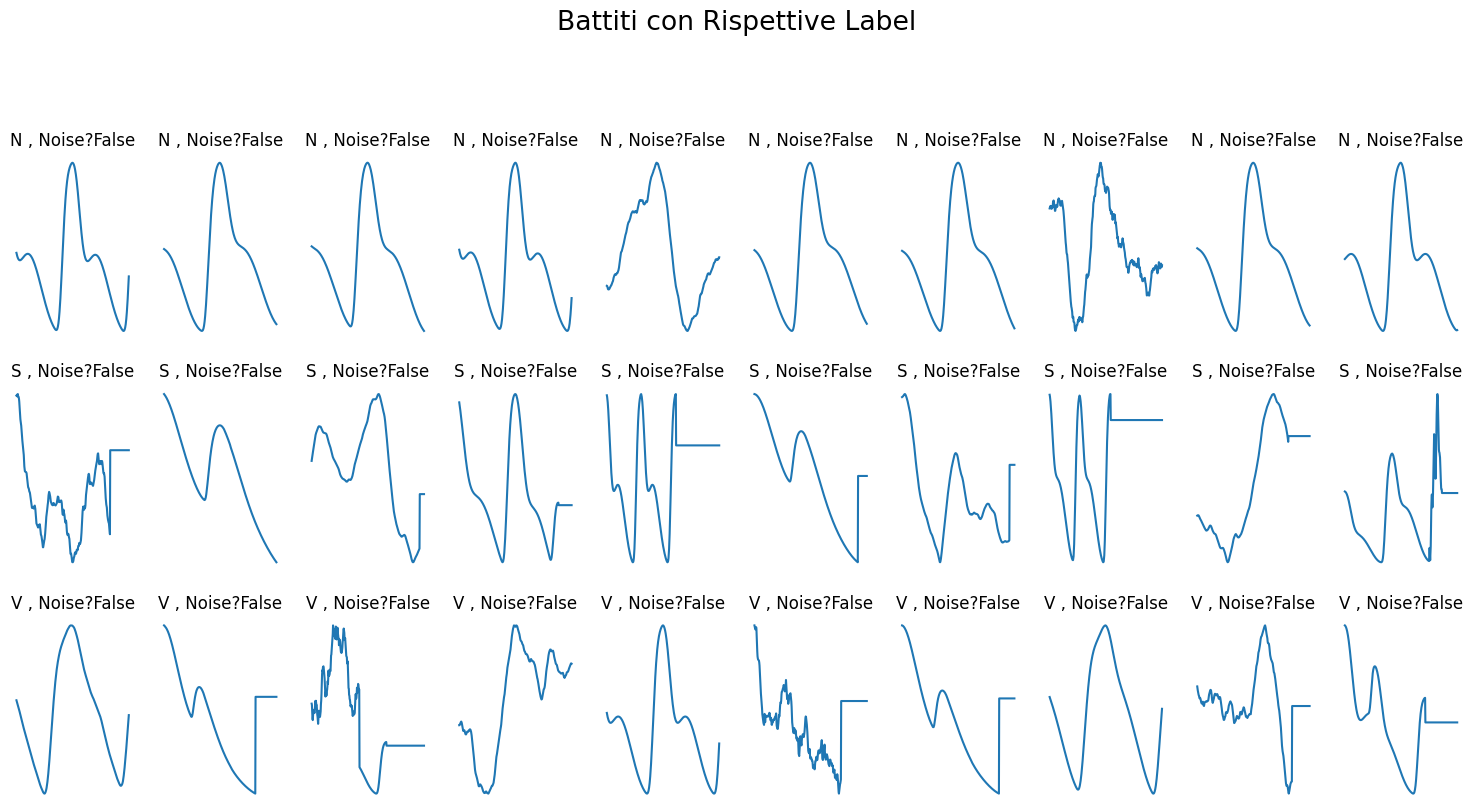

In [ ]:
# Visualizza 10 battiti di tipo 'N', 'S' e 'V' per il set di allenamento
plot_beats_with_labels(normalized_test_beats, test_beats_labels_onehot, label_mapping, num_samples_per_class=10)

In [ ]:
normalized_train_beats = normalized_train_beats[:,:, np.newaxis]
normalized_val_beats = normalized_val_beats[:,:, np.newaxis]
normalized_test_beats = normalized_test_beats[:,:, np.newaxis]

print('TRAIN:')
print(normalized_train_beats.shape)
print(train_beats_labels_onehot.shape)

print('VAL:')
print(normalized_val_beats.shape)
print(val_beats_labels_onehot.shape)

print('TEST:')
print(normalized_test_beats.shape)
print(test_beats_labels_onehot.shape)

TRAIN:
(36259, 400, 1)
(36259, 3)
VAL:
(5234, 400, 1)
(5234, 3)
TEST:
(4511, 400, 1)
(4511, 3)


In [ ]:
#SHUFFLE DATA
# Shuffling per il set di allenamento
train_indices = np.arange(len(normalized_train_beats))
np.random.shuffle(train_indices)

normalized_train_beats = normalized_train_beats[train_indices]
train_beats_labels_onehot = train_beats_labels_onehot[train_indices]

# Shuffling per il set di validazione
val_indices = np.arange(len(normalized_val_beats))
np.random.shuffle(val_indices)

normalized_val_beats = normalized_val_beats[val_indices]
val_beats_labels_onehot = val_beats_labels_onehot[val_indices]

# Shuffling per il set di test
test_indices = np.arange(len(normalized_test_beats))
np.random.shuffle(test_indices)

normalized_test_beats = normalized_test_beats[test_indices]
test_beats_labels_onehot = test_beats_labels_onehot[test_indices]

In [ ]:
print(f'normalized_train_beats: {normalized_train_beats.shape}')
print(f'train_beats_labels_onehot: {train_beats_labels_onehot.shape}')

if False:
    z = np.int64(0)
    o = np.int64(1)
else:
    z = np.array([1, 0])
    o = np.array([0, 1])
# TAKE ONLY S AND V FOR TRAIN
train_SV = []
train_SV_labels_onehot = []

for beat, label in zip(normalized_train_beats, train_beats_labels_onehot):
    if np.argmax(label)==1:
        train_SV.append(beat)
        train_SV_labels_onehot.append(z)
    elif np.argmax(label)==2:
        train_SV.append(beat)
        train_SV_labels_onehot.append(o)

train_SV = np.array(train_SV)
train_SV_labels_onehot = np.array(train_SV_labels_onehot)

# TAKE ONLY S AND V FOR VAL
val_SV = []
val_SV_labels_onehot = []

for beat, label in zip(normalized_val_beats, val_beats_labels_onehot):
    if np.argmax(label)==1:
        val_SV.append(beat)
        val_SV_labels_onehot.append(z)
    elif np.argmax(label)==2:
        val_SV.append(beat)
        val_SV_labels_onehot.append(o)

val_SV = np.array(val_SV)
val_SV_labels_onehot = np.array(val_SV_labels_onehot)

# TAKE ONLY S AND V FOR TEST
test_SV = []
test_SV_labels_onehot = []

for beat, label in zip(normalized_test_beats, test_beats_labels_onehot):
    if np.argmax(label)==1:
        test_SV.append(beat)
        test_SV_labels_onehot.append(z)
    elif np.argmax(label)==2:
        test_SV.append(beat)
        test_SV_labels_onehot.append(o)

test_SV = np.array(test_SV)
test_SV_labels_onehot = np.array(test_SV_labels_onehot)


print(f'train_SV: {train_SV.shape}')
print(f'train_SV_labels_onehot: {train_SV_labels_onehot.shape}')
print(f'val_SV: {val_SV.shape}')
print(f'val_SV_labels_onehot: {val_SV_labels_onehot.shape}')
print(f'test_SV: {test_SV.shape}')
print(f'test_SV_labels_onehot: {test_SV_labels_onehot.shape}')

normalized_train_beats: (36259, 400, 1)
train_beats_labels_onehot: (36259, 3)
train_SV: (11869, 400, 1)
train_SV_labels_onehot: (11869, 2)
val_SV: (1515, 400, 1)
val_SV_labels_onehot: (1515, 2)
test_SV: (620, 400, 1)
test_SV_labels_onehot: (620, 2)


### Weights

In [ ]:
#WEIGHT CLASSES:
from sklearn.utils.class_weight import compute_class_weight

def calculating_class_weights(y_true):
    num_classes = y_true.shape[1]
    weights = np.empty([num_classes, 2])
    for i in range(num_classes):
        weights[i] = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_true[:, i])
    return weights

# Supponendo che y_train sia la tua variabile train_beats_labels_onehot
class_weights = calculating_class_weights(train_SV_labels_onehot)

# Modifica le chiavi per rappresentare le tue classi (0, 1, 2)
keys = np.arange(2)
weight_dictionary_fold = dict(zip(keys, class_weights.T[1]))
class_w = [v for v in weight_dictionary_fold.values()]
class_w

[0.8548689138576779, 1.2044854881266491]

##MODELS

In [ ]:
LR = 0.001
BATCH_SIZE = 64
EPOCHS = 50
PATIENCE = 10
num_classes = 2
OPTIMIZER = tfk.optimizers.Adam(LR)
LOSS = tfk.losses.CategoricalCrossentropy()

### Losses

In [ ]:
ALPHA = 0.3
BETA = 0.7

def TverskyLoss(targets, inputs, alpha=ALPHA, beta=BETA, smooth=1e-6):

        #flatten label and prediction tensors
        inputs = tfkl.Flatten()(inputs)
        targets = tfkl.Flatten()(targets)
        #True Positives, False Positives & False Negatives
        TP = tf.math.reduce_sum((inputs * targets))
        FP = tf.math.reduce_sum(((1-targets) * inputs))
        FN = tf.math.reduce_sum((targets * (1-inputs)))

        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)

        return 1 - Tversky

###BASIC CNN

In [ ]:
cnn_model = Sequential([
    Conv1D(filters=16, kernel_size=3, padding='valid',
                        activation='relu', input_shape=(400, 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3,
                        padding='valid', activation='relu'),
    MaxPooling1D(pool_size=2),
    GlobalMaxPooling1D(),
    Dense(128, activation=tf.nn.relu),
    Dropout(0.1),
    Dense(num_classes, activation=tf.nn.softmax)
])

cnn_model.compile(
    optimizer = tfk.optimizers.Adam(LR),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 398, 16)           64        
                                                                 
 max_pooling1d (MaxPooling1  (None, 199, 16)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 197, 64)           3136      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 98, 64)            0         
 g1D)                                                            
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                        

In [ ]:
history = cnn_model.fit(
    x = train_SV,
    y = train_SV_labels_onehot,
    validation_data=(val_SV, val_SV_labels_onehot),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    class_weight = weight_dictionary_fold
).history

Epoch 1/50
186/186 [==============================] - 6s 11ms/step - loss: 0.6810 - accuracy: 0.5717 - val_loss: 0.6791 - val_accuracy: 0.5947
Epoch 2/50
186/186 [==============================] - 1s 7ms/step - loss: 0.6739 - accuracy: 0.5707 - val_loss: 0.6757 - val_accuracy: 0.5908
Epoch 3/50
186/186 [==============================] - 1s 5ms/step - loss: 0.6684 - accuracy: 0.5725 - val_loss: 0.7290 - val_accuracy: 0.6191
Epoch 4/50
186/186 [==============================] - 1s 5ms/step - loss: 0.6725 - accuracy: 0.5662 - val_loss: 0.6807 - val_accuracy: 0.6178
Epoch 5/50
186/186 [==============================] - 1s 5ms/step - loss: 0.6594 - accuracy: 0.5663 - val_loss: 0.6634 - val_accuracy: 0.6172
Epoch 6/50
186/186 [==============================] - 1s 5ms/step - loss: 0.6700 - accuracy: 0.5841 - val_loss: 0.7240 - val_accuracy: 0.6132
Epoch 7/50
186/186 [==============================] - 1s 6ms/step - loss: 0.6684 - accuracy: 0.5764 - val_loss: 0.6720 - val_accuracy: 0.5861
Epoch

In [ ]:
def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Conv1D(128,3,padding='same',activation='relu')(cnn)
    gap = tfkl.GlobalAveragePooling1D()(cnn)
    dropout = tfkl.Dropout(.5, seed=seed)(gap)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model_cnn_2 = build_1DCNN_classifier((400, 1), 2)
model_cnn_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 400, 1)]          0         
                                                                 
 conv1d_17 (Conv1D)          (None, 400, 128)          512       
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 200, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_18 (Conv1D)          (None, 200, 128)          49280     
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 128)               0     

In [ ]:
# Train the model
history = model_cnn_2.fit(
    x = train_SV,
    y = train_SV_labels_onehot,
    validation_data=(val_SV, val_SV_labels_onehot),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=PATIENCE, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ],
    #class_weight = weight_dictionary_fold

).history

NameError: name 'model' is not defined

###VGG

In [ ]:
vgg_weight = Sequential()

vgg_weight.add(Conv1D(input_shape=(400,1),filters=64,kernel_size=3,padding="valid", activation="relu"))
vgg_weight.add(Conv1D(filters=64,kernel_size=3,padding="valid", activation="relu"))
vgg_weight.add(MaxPooling1D(pool_size=2,strides=2))
vgg_weight.add(Conv1D(filters=128, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(Conv1D(filters=128, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(MaxPooling1D(pool_size=2,strides=2))
vgg_weight.add(Conv1D(filters=256, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(Conv1D(filters=256, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(Conv1D(filters=256, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(MaxPooling1D(pool_size=2,strides=2))
vgg_weight.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(MaxPooling1D(pool_size=2,strides=2))
vgg_weight.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(Conv1D(filters=512, kernel_size=3, padding="valid", activation="relu"))
vgg_weight.add(MaxPooling1D(pool_size=2,strides=2))
vgg_weight.add(tfkl.GlobalMaxPooling1D())
vgg_weight.add (Dense(512, activation='relu'))
#vgg_weight.add (Dropout(0.4))
vgg_weight.add (Dense(2,activation='softmax'))


vgg_weight.compile(
    optimizer = tfk.optimizers.Adam(),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history = vgg_weight.fit(
    x = normalized_train_beats,
    y = train_beats_labels_onehot,
    validation_data=(normalized_val_beats, val_beats_labels_onehot),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    class_weight = weight_dictionary_fold
).history

Epoch 1/50
68/68 [==============================] - 23s 199ms/step - loss: 0.6932 - accuracy: 0.4864 - val_loss: 0.7130 - val_accuracy: 0.3025
Epoch 2/50
68/68 [==============================] - 7s 110ms/step - loss: 0.6925 - accuracy: 0.5083 - val_loss: 0.9659 - val_accuracy: 0.3025
Epoch 3/50
68/68 [==============================] - 8s 112ms/step - loss: 0.6967 - accuracy: 0.4535 - val_loss: 0.6986 - val_accuracy: 0.3025
Epoch 4/50
68/68 [==============================] - 8s 111ms/step - loss: 0.6930 - accuracy: 0.4429 - val_loss: 0.7026 - val_accuracy: 0.3025
Epoch 5/50
68/68 [==============================] - 7s 110ms/step - loss: 0.6925 - accuracy: 0.4589 - val_loss: 0.6905 - val_accuracy: 0.5238
Epoch 6/50
68/68 [==============================] - 7s 107ms/step - loss: 0.6793 - accuracy: 0.5668 - val_loss: 0.6930 - val_accuracy: 0.8987
Epoch 7/50
68/68 [==============================] - 7s 107ms/step - loss: 0.6983 - accuracy: 0.4855 - val_loss: 0.7201 - val_accuracy: 0.3025
Epoch

KeyboardInterrupt: 

###RESNET

In [ ]:
# ResNet model definition


def ResBs_Conv(block_input, num_filters):

    # 0. Filter Block input and BatchNormalization
    block_shortcut = Conv1D(num_filters, kernel_size=7, strides=2,  padding='same')(block_input)
    block_shortcut = BatchNormalization()(block_shortcut)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, strides=2, padding='same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.2)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding='same')(dropout) # per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_shortcut, norm2])

    # 4. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

def ResBs_Identity(block_input, num_filters):

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.2)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, norm2])

    # 4. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

def resnet(N=8, ch=12, win_len=5000, classes=9):
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal')

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input)
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)

    # B.5 ResBs (x8) blocks
    # First two ResNet blocks are identity blocks
    ResNet = ResBs_Identity(ResNet, 64)
    ResNet = ResBs_Identity(ResNet, 64)

    filters = 64
    M = int((N - 2)/2)
    for i in range(M):
        filters = filters * 2
        # define N-th ResBs block
        ResNet = ResBs_Conv(ResNet, filters)
        ResNet = ResBs_Identity(ResNet, filters)

    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)

    # Sigmoid activation function on the last layer
    ResNet = Dense(classes, activation='softmax',  name='softmax_classifier')(ResNet)

    # Finally the model is composed by connecting inputs to outputs:
    model = Model(inputs=[ecg_input],outputs=ResNet)

    return model

In [ ]:
resNet_model = resnet(N=8, ch=1, win_len=WINDOW_SIZE, classes=2)

resNet_model.compile(
    optimizer = tfk.optimizers.Adam(LR),
    loss = tfk.losses.CategoricalCrossentropy(), #CategoricalFocalCrossentropy(alpha=class_w, gamma=2.0),
    metrics = ['accuracy', 'Precision', 'Recall' ]
)
#resNet_model.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE)
reduce_lr = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=1e-8)

history = resNet_model.fit(
    x = train_SV,
    y = train_SV_labels_onehot,
    validation_data=(val_SV, val_SV_labels_onehot),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [callback],
    class_weight = weight_dictionary_fold
).history

Epoch 1/50
186/186 [==============================] - 30s 74ms/step - loss: 1.1019 - accuracy: 0.6164 - precision: 0.6164 - recall: 0.6164 - val_loss: 1.9091 - val_accuracy: 0.4066 - val_precision: 0.4066 - val_recall: 0.4066
Epoch 2/50
186/186 [==============================] - 13s 72ms/step - loss: 0.6455 - accuracy: 0.6728 - precision: 0.6728 - recall: 0.6728 - val_loss: 0.7034 - val_accuracy: 0.5459 - val_precision: 0.5459 - val_recall: 0.5459
Epoch 3/50
186/186 [==============================] - 13s 69ms/step - loss: 0.6103 - accuracy: 0.6867 - precision: 0.6867 - recall: 0.6867 - val_loss: 0.6888 - val_accuracy: 0.5947 - val_precision: 0.5947 - val_recall: 0.5947
Epoch 4/50
186/186 [==============================] - 13s 72ms/step - loss: 0.5380 - accuracy: 0.7187 - precision: 0.7187 - recall: 0.7187 - val_loss: 1.0876 - val_accuracy: 0.5446 - val_precision: 0.5446 - val_recall: 0.5446
Epoch 5/50
186/186 [==============================] - 13s 69ms/step - loss: 0.5469 - accuracy: 0

###RESNET_CBAM

In [ ]:
#hint: use tf.reduce_mean(in_block, axis=()) for avg pooling
# and tf.reduce_max(in_block, axis=()) for max pooling

def CBAM_block(in_block, ch, ratio=16):

    """
    @Convolutional Block Attention Module
    """

    _, length, channel = in_block.get_shape()  # (B, L, C)

    # channel attention
    avg_pool = tf.reduce_mean(in_block, axis=(1), keepdims=True)   # (B, 1, C)
    max_pool = tf.reduce_max(in_block, axis=(1), keepdims=True)  # (B, 1, C)

    dense1 = Dense(ch//ratio, activation='relu')
    avg_reduced = dense1(avg_pool) # (B, 1, C // r)
    max_reduced = dense1(max_pool) # (B, 1, C // r)

    dense2 = Dense(ch)
    avg_attention = dense2(avg_reduced) # (B, 1, C)
    max_attention = dense2(max_reduced) # (B, 1, C)

    x = tf.add(avg_attention, max_attention)   # (B, 1, C)
    x = tf.nn.sigmoid(x)        # (B, 1, C) to normalize attention scores between 0-1
    x = tf.multiply(in_block, x)   # (B, L, C)

    # spatial attention
    y_mean = tf.reduce_mean(x, axis=-1, keepdims=True)  # (B, L, 1)
    y_max = tf.reduce_max(x, axis=-1, keepdims=True)  # (B, L, 1)
    y = tf.concat([y_mean, y_max], axis=-1)     # (B, L, 2)
    y = tf.keras.layers.Conv1D(filters=1, kernel_size=7, padding='same', activation=tf.nn.sigmoid)(y)    # (B, L, 1)

    y = tf.multiply(x, y)  # (B, L, C)

    return y

In [ ]:
# ResNet with Convolutional Block Attention Module definition


def ResBs_CBAM_Conv(block_input, num_filters):

    # 0. Filter Block input and BatchNormalization
    block_input_short = Conv1D(num_filters, kernel_size=7, strides=2,  padding = 'valid')(block_input)
    block_input_short = BatchNormalization()(block_input_short)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, strides=2, padding= 'valid')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.2)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. CBAM block (fucntion defined above)
    CBAM = CBAM_block(norm2, ch=num_filters)

    # 4. Summing Layer (adding a residual connection)
    sum = Add()([block_input_short, CBAM])

    # 5. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

def ResBs_CBAM_Identity(block_input, num_filters):

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.2)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout) #per avere concordanza
    norm2 = BatchNormalization()(conv2)

    # 3. CBAM block (fucntion defined above)
    CBAM = CBAM_block(norm2, ch=num_filters)

    # 4. Summing Layer (adding a residual connection)
    sum = Add()([block_input, CBAM])
    # 5. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

# model integrating deep + wide
def resnet_CBAM_deep_wide(N=8, ch=12, win_len=400, num_wide_features= 36, classes=9):
    # A. Wide features
    wide_input = Input(shape= (num_wide_features, ), name = 'wide_features')
    wide_branch = Dense(13, activation='relu', name='wide_features_dense')(wide_input)

    # B. ECG window input of shape (batch_size,  WINDOW_LEN, CHANNELS)
    ecg_input = Input(shape=(win_len, ch), name='ecg_signal')

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(ecg_input)
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)

    # B.5 ResBs (x8) blocks
    # The number of filters starts from 64 and doubles every two blocks

    # First two ResNet blocks are identity blocks
    ResNet = ResBs_CBAM_Identity(ResNet, 64)
    ResNet = ResBs_CBAM_Identity(ResNet, 64)

    filters = 64
    M= int((N -2 )/2)
    for i in range(M):
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_CBAM_Conv(ResNet, filters)
        ResNet = ResBs_CBAM_Identity(ResNet, filters)

    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)

    shared_path = tfkl.concatenate([ResNet, wide_branch], name='concat_layer')
    shared_path = Dense(classes, activation='softmax', name='softmax_classifier')(shared_path)

    # Finally the model is composed by connecting inputs to outputs:
    model = Model(inputs=[ecg_input,  wide_input],outputs=shared_path)

    return model

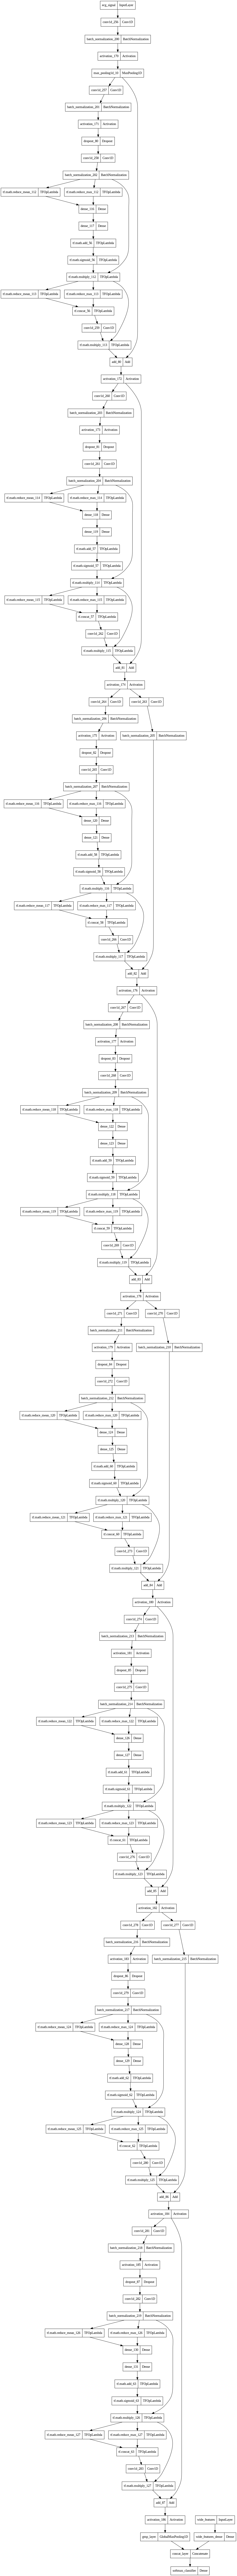

In [ ]:
resNetCBAM_model = resnet_CBAM_deep_wide(N=8, ch=1, win_len=400, classes=2)

resNetCBAM_model.compile(
    optimizer = tfk.optimizers.Adam(LR),
    loss = tfk.losses.CategoricalCrossentropy(),
    metrics = ['accuracy', 'Precision', 'Recall' ]
)
tf.keras.utils.plot_model(
    resNetCBAM_model,
    to_file="resNet_model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None)

In [ ]:
history = resNetCBAM_model.fit(
    x = normalized_train_beats,
    y = train_beats_labels_onehot,
    validation_data=(normalized_val_beats, val_beats_labels_onehot),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    #class_weight = weight_dictionary_fold
).history

###LSTM

In [ ]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model_LSTM = build_LSTM_classifier((400,1), num_classes)
model_LSTM.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 400, 1)]          0         
                                                                 
 lstm_6 (LSTM)               (None, 400, 128)          66560     
                                                                 
 lstm_7 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_30 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dense_17 (Dense)            (None, 3)                 387       
                                                                 
Total params: 215043 (840.01 KB)
Trainable params: 215043 (84

In [ ]:
# Train the model
history = model_LSTM.fit(
    x = normalized_train_beats,
    y = train_beats_labels_onehot,
    batch_size = 128,
    epochs = 200,
    validation_data = (normalized_val_beats, val_beats_labels_onehot),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
136/136 [==============================] - 10s 52ms/step - loss: 0.8355 - accuracy: 0.6363 - val_loss: 0.7146 - val_accuracy: 0.6988 - lr: 0.0010
Epoch 2/200
136/136 [==============================] - 6s 46ms/step - loss: 0.8312 - accuracy: 0.6283 - val_loss: 0.9438 - val_accuracy: 0.6739 - lr: 0.0010
Epoch 3/200
136/136 [==============================] - 7s 51ms/step - loss: 0.7818 - accuracy: 0.6557 - val_loss: 0.7719 - val_accuracy: 0.6774 - lr: 0.0010
Epoch 4/200
136/136 [==============================] - 6s 46ms/step - loss: 0.6320 - accuracy: 0.7145 - val_loss: 0.5557 - val_accuracy: 0.7069 - lr: 0.0010
Epoch 5/200
136/136 [==============================] - 6s 46ms/step - loss: 0.5874 - accuracy: 0.7463 - val_loss: 0.6923 - val_accuracy: 0.7235 - lr: 0.0010
Epoch 6/200
136/136 [==============================] - 6s 46ms/step - loss: 0.8089 - accuracy: 0.6614 - val_loss: 0.6282 - val_accuracy: 0.7356 - lr: 0.0010
Epoch 7/200
136/136 [==============================] - 7s

KeyboardInterrupt: 

###BiLSTM

In [ ]:
def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
    dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(LR), metrics='accuracy')

    # Return the model
    return model

In [ ]:
model_biLSTM = build_BiLSTM_classifier((WINDOW_SIZE,1), num_classes)
#model_biLSTM.summary()

In [ ]:
# Train the model
history = model_biLSTM.fit(
    x = train_SV,
    y = train_SV_labels_onehot,
    batch_size = 128,
    epochs = EPOCHS,
    #class_weight=weight_dictionary_fold,
    validation_data = (val_SV, val_SV_labels_onehot),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='min', patience=PATIENCE, restore_best_weights=True)]
).history

Epoch 1/50
93/93 [==============================] - 20s 132ms/step - loss: 0.6741 - accuracy: 0.5761 - val_loss: 0.7370 - val_accuracy: 0.3815
Epoch 2/50
93/93 [==============================] - 11s 118ms/step - loss: 0.6550 - accuracy: 0.5836 - val_loss: 0.7063 - val_accuracy: 0.5069
Epoch 3/50
93/93 [==============================] - 11s 118ms/step - loss: 0.6507 - accuracy: 0.5853 - val_loss: 0.7652 - val_accuracy: 0.3710
Epoch 4/50
93/93 [==============================] - 11s 118ms/step - loss: 0.6482 - accuracy: 0.5916 - val_loss: 0.7270 - val_accuracy: 0.4020
Epoch 5/50
93/93 [==============================] - 11s 119ms/step - loss: 0.6464 - accuracy: 0.5956 - val_loss: 0.7337 - val_accuracy: 0.3650
Epoch 6/50
93/93 [==============================] - 12s 126ms/step - loss: 0.6448 - accuracy: 0.5893 - val_loss: 0.7142 - val_accuracy: 0.5129
Epoch 7/50
93/93 [==============================] - 11s 115ms/step - loss: 0.6462 - accuracy: 0.5944 - val_loss: 0.7399 - val_accuracy: 0.3558

## EVALUATION

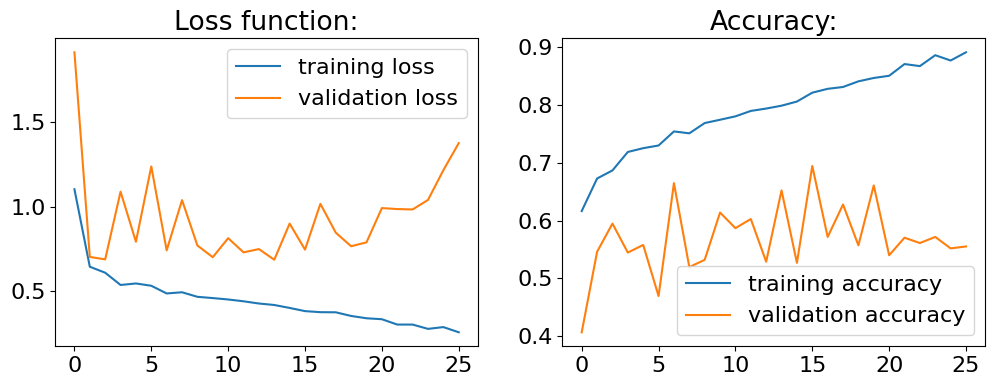

In [ ]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.plot(history['loss'], label="training loss")
plt.plot(history['val_loss'], label="validation loss")
plt.title('Loss function:')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['accuracy'], label="training accuracy")
plt.plot(history['val_accuracy'], label="validation accuracy")
plt.title('Accuracy:')
plt.legend()

20/20 [==============================] - 2s 29ms/step
Accuracy: 0.4048
Precision: 0.3814
Recall: 0.4161
F1: 0.3652


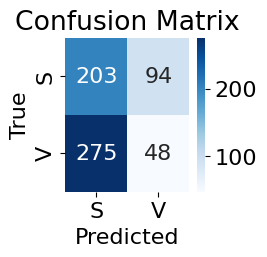

In [ ]:
mode = "TEST" # "VAL"

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(class_names), len(class_names)))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

if mode=="TEST":
    to_pred = test_SV
    labs = test_SV_labels_onehot
else:
    to_pred = val_SV
    labs = val_SV_labels_onehot

predictions = model_biLSTM.predict(to_pred)
predictions =  np.argmax(predictions, axis=-1)
labs = np.argmax(labs, axis=-1)
# Compute the classification metrics
accuracy = accuracy_score(labs, predictions)
precision = precision_score(labs, predictions, average='macro')
recall = recall_score(labs, predictions, average='macro')
f1 = f1_score(labs, predictions, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plot_confusion_matrix(labs, predictions, class_names=["S", "V"])
#plot_confusion_matrix(val_true_classes, val_predictions_classes, class_names=["N", "notN"])

## ENSEMBLE

In [ ]:
mode = "TEST" # "VAL"

if mode=="TEST":
    to_pred = test_SV
    labs = test_SV_labels_onehot
else:
    to_pred = val_SV
    labs = val_SV_labels_onehot

preds_model1 = model_biLSTM.predict(to_pred)
preds_model2 = resNet_model.predict(to_pred)
preds_model3 = cnn_model.predict(to_pred)
preds_model4 = model_LSTM.predict(to_pred)
ensemble_preds = np.mean([preds_model1, preds_model2, preds_model3, preds_model4], axis=0)
final_predictions = np.argmax(ensemble_preds, axis=1)
labs = np.argmax(labs, axis=-1)

# Compute the classification metrics
accuracy = accuracy_score(labs, predictions)
precision = precision_score(labs, predictions, average='macro')
recall = recall_score(labs, predictions, average='macro')
f1 = f1_score(labs, predictions, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plot_confusion_matrix(labs, predictions, class_names=["S", "V"])

## SAVE MODEL

In [ ]:
resNet_model.save("resnet_model.h5")

## FULL CLASSIFIER

Scheme of the full classifier (Here we use the already extracted beats):

> 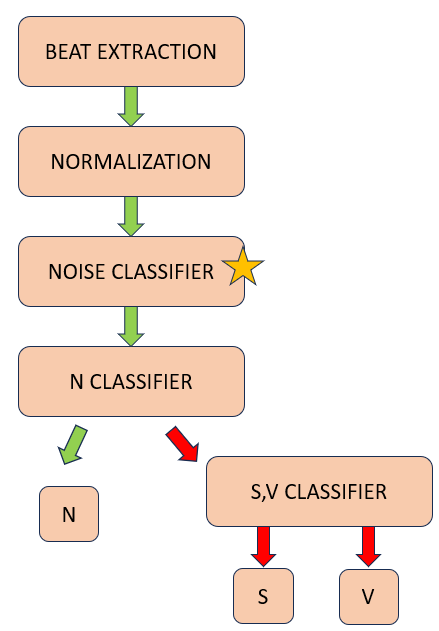



In [ ]:
model_N = tfk.models.load_model("weights/resnet-Final")
model_SV = tfk.models.load_model("weights/resnet_model065.h5")

141/141 [==============================] - 2s 11ms/step
prediction N/nonN: (4511,), unique: [0 1], counts: [3480 1031]
141/141 [==============================] - 2s 13ms/step
prediction N/nonN: (4511,), unique: [1 2], counts: [3442 1069]
Accuracy: 0.7907
Precision: 0.5116
Recall: 0.5968
F1: 0.5376


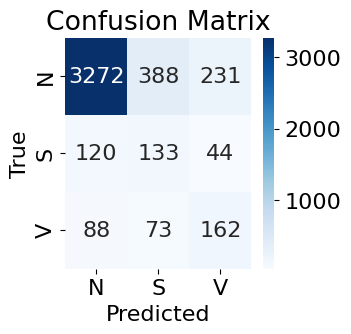

In [ ]:
mode = "TEST" # "VAL"

if mode=="TEST":
    to_pred = normalized_test_beats
    labs = np.argmax(test_beats_labels_onehot, axis=-1)
else:
    to_pred = normalized_val_beats
    labs = np.argmax(val_beats_labels_onehot, axis=-1)

predictions_M = model_N.predict(to_pred)
predictions_M = (predictions_M > 0.62948537).astype(np.int64).squeeze(-1)
unique_elements, counts = np.unique(predictions_M, return_counts=True)
print(f'prediction N/nonN: {predictions_M.shape}, unique: {unique_elements}, counts: {counts}')

predictions_SV = model_SV.predict(to_pred)
predictions_SV =  np.argmax(predictions_SV, axis=-1)
predictions_SV = np.where(predictions_SV==0, 1, 2)
unique_elements, counts = np.unique(predictions_SV, return_counts=True)
print(f'prediction N/nonN: {predictions_SV.shape}, unique: {unique_elements}, counts: {counts}')

predictions = np.where(predictions_M==0, predictions_M, predictions_SV)
accuracy = accuracy_score(labs, predictions)
precision = precision_score(labs, predictions, average='macro')
recall = recall_score(labs, predictions, average='macro')
f1 = f1_score(labs, predictions, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plot_confusion_matrix(labs, predictions, class_names=["N", "S", "V"])